<a href="https://colab.research.google.com/github/enicaking/bluetab-uc3m-project-repo/blob/main/Bluetab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

<center>

<h1><b>Fraud Detection Project</b></h1>
<h3>Universidad Carlos III de Madrid · Bluetab</h3>

<p><em>Development of a predictive system using Machine Learning to identify fraudulent transactions and strengthen financial security.</em></p>

</center>

---

### Notebook Overview

This notebook is part of the *Bluetab–UC3M Fraud Detection Project*.  
Its main goal is to explore and merge the different datasets provided by the company (`customers_dirty.csv`, `transactions_dirty.csv`, `locations_dirty.csv`, and `creditcard.csv`) to build a clean and unified database for further analysis.  

Throughout this notebook, we:
- Load and inspect the raw data.  
- Perform initial cleaning and consistency checks.  
- Merge datasets into a single structured DataFrame.  
- EDA


---


# **Libraries**

In [1]:
!pip install pvlib
!pip install catboost
!pip install chardet
!pip install xgboost
!pip install polars
!pip install lightgbm
!pip install tabulate
!pip install imbalanced-learn
!pip install scikit-learn
!pip install collections

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections


In [2]:
import sys
import time
import warnings
import chardet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import os
from IPython.display import display

from datetime import datetime, timedelta
from itertools import combinations
from pytz import timezone

from tqdm import tqdm
from tqdm.auto import tqdm

from pvlib.location import Location
from scipy.stats import pearsonr


from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
import lightgbm as lgbm
from catboost import CatBoostRegressor, CatBoostClassifier

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTENC

np.random.seed(123)

# **Upload the datasets**

In [3]:
# If working locally
# credit_df = pd.read_csv('content/creditcard.csv')
# transactions_df = pd.read_csv('content/transactions_dirty.csv')
# locations_df = pd.read_csv('content/locations_dirty.csv')
# customers_df = pd.read_csv('content/customers_dirty.csv')

In [4]:
# If working on Colab
transactions_df = pd.read_csv('/content/transactions_dirty.csv')
locations_df = pd.read_csv('/content/locations_dirty.csv')
customers_df = pd.read_csv('/content/customers_dirty.csv')
flags_df = pd.read_csv('/content/flags.csv')
time_table_df = pd.read_csv('/content/time_table.csv')
devices_df = pd.read_csv('/content/devices.csv')

# **1. Raw Data Exploration**
This section focuses on the initial exploration of the four raw datasets provided by Bluetab: `customers_dirty.csv`, `transactions_dirty.csv`, `locations_dirty.csv`, and `creditcard.csv`.

The objective is to understand the structure, quality, and characteristics of each dataset, performing an EDA of each one. By analyzing them separately, we can identify inconsistencies, missing values, duplicates, and potential variables of interest for the fraud detection model.

## **Transactions**

In [5]:
display(transactions_df.head())
transactions_df.shape

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V24,V25,V26,V27,V28,Amount,Class,transaction_id,customer_id,device_id
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,822947e3-96bc-4124-8e77-75fc791a6308,1102,DEV_0004
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,107b9ba3-0cd1-48ab-b548-ed6282de31af,1435,DEV_0039
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,64a68036-03d7-434f-b4e9-6af563252772,1860,DEV_0035
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,b3fcacd4-a564-479a-a9b9-cd04d10efed5,1270,DEV_0001
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,2a51fbde-2f19-4ea5-bb7e-cefb24cabd36,1106,DEV_0024


(286815, 33)

In [6]:
print(transactions_df['transaction_id'].duplicated().sum())

500


In [7]:
transactions_df.drop_duplicates(inplace=True) # Complete equal rows are dropped
print(transactions_df['transaction_id'].duplicated().sum()) # There are 3 repeated ids in rows not completely equal

3


In [8]:
duplicated_transactions = transactions_df[transactions_df['transaction_id'].duplicated(keep=False)] # Get all rows with duplicated transaction IDs
print("Duplicated transaction IDs in transactions_df:")
print(duplicated_transactions)

Duplicated transaction IDs in transactions_df:
              V1        V2        V3        V4        V5        V6        V7  \
13213  -2.039728  0.965692  2.166568 -0.005581 -0.086848 -0.098832 -0.216829   
31857  -1.185284  0.512991  2.057373  0.376168  0.234964  0.104018  0.140999   
128428 -1.236607  0.610138  1.576652  1.282104 -0.265792 -0.374496 -0.268472   
286366 -1.236607  0.610138  1.576652  1.282104 -0.265792 -0.374496 -0.268472   
286537 -2.039728  0.965692  2.166568 -0.005581 -0.086848 -0.098832 -0.216829   
286783 -1.185284  0.512991  2.057373  0.376168  0.234964  0.104018  0.140999   

              V8        V9       V10  ...       V24       V25       V26  \
13213   0.198205  1.605322  0.364846  ...  0.157698 -0.031629  0.211652   
31857   0.329286 -0.358042 -0.077797  ... -0.025780 -0.152223 -0.523562   
128428  0.471094 -0.561624 -0.352570  ...  0.454560 -0.392421 -0.232860   
286366  0.471094 -0.561624 -0.352570  ...  0.454560 -0.392421 -0.232860   
286537  0.198205 

The amount is the same, the customer and device id are different and it is impossible to have two equal transaction ids, so we compared with other database.

In [9]:
duplicated_df = transactions_df[transactions_df['transaction_id'].duplicated(keep=False)].copy()
aux = pd.merge(duplicated_df, customers_df, on='customer_id', how='inner')
display(aux)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,transaction_id,customer_id,device_id,name,age,email,phone,country,credit_score,join_date
0,-2.039728,0.965692,2.166568,-0.005581,-0.086848,-0.098832,-0.216829,0.198205,1.605322,0.364846,...,a995c6a8-ef9d-4c4f-928d-7149a5549fc8,1163,DEV_0100,Ariel Sandoval,70,NaN,689.731.8692x8972,Serbia,787,2021-09-17
1,-1.236607,0.610138,1.576652,1.282104,-0.265792,-0.374496,-0.268472,0.471094,-0.561624,-0.352570,...,70a09c87-2693-4455-9373-01c07f4cbc65,1955,DEV_0089,Anthony Rodriguez,38,xmalone@example.org,611-818-2422x412,Greenland,702,2023-08-27
2,-1.185284,0.512991,2.057373,0.376168,0.234964,0.104018,0.140999,0.329286,-0.358042,-0.077797,...,7dd260b9-5836-4d26-9163-ceff19cee458,1617,DEV_0038,Virginia Casey,33,carpenterjorge@example.net,001-821-229-9642,Luxembourg,493,2022-06-20


In [10]:
# Remove the rows which are incorrect (the customer_id does not match in the transaction database with the customer database)
transactions_df = transactions_df[~(
    (transactions_df['transaction_id'] == "a995c6a8-ef9d-4c4f-928d-7149a5549fc8") &
    (transactions_df['customer_id'] == 99180)
)]

transactions_df = transactions_df[~(
    (transactions_df['transaction_id'] == "70a09c87-2693-4455-9373-01c07f4cbc65") &
    (transactions_df['customer_id'] == 99172)
)]

transactions_df = transactions_df[~(
    (transactions_df['transaction_id'] == "7dd260b9-5836-4d26-9163-ceff19cee458") &
    (transactions_df['customer_id'] == 99209)
)]

In [11]:
print(transactions_df.shape)

(286315, 33)


## **Locations**

In [12]:
display(locations_df.head())
locations_df.shape

,transaction_id,ip_address,country,city,zip_code,merchant
0,822947e3-96bc-4124-8e77-75fc791a6308,83.63.232.13,Australia,Perth,NaN,Davis-Parker
1,107b9ba3-0cd1-48ab-b548-ed6282de31af,89.213.161.51,Australia,Perth,57376.0,Garcia-Mitchell
2,64a68036-03d7-434f-b4e9-6af563252772,140.231.3.186,France,Lyon,19277.0,Mccann-Snow
3,b3fcacd4-a564-479a-a9b9-cd04d10efed5,40.46.209.108,Germany,Berlin,93260.0,Jones Inc
4,2a51fbde-2f19-4ea5-bb7e-cefb24cabd36,174.155.184.108,Australia,Melbourne,97401.0,Rodriguez Inc


(286315, 6)

In [13]:
print(locations_df['transaction_id'].duplicated().sum())

0


## **Customers**

In [14]:
display(customers_df.head())
customers_df.shape

,customer_id,name,age,email,phone,country,credit_score,join_date
0,1102,Allison Hill,56,qjacobson@example.org,6502166799,Gambia,787,2024-03-18
1,1435,Noah Rhodes,69,ylopez@example.com,767.389.9730x8069,Georgia,582,2021-09-04
2,1860,Angie Henderson,46,seanbaker@example.com,567-917-9576x024,Mayotte,765,2023-11-19
3,1270,Daniel Wagner,32,jeremy49@example.org,(873)783-9597x246,Papua New Guinea,612,2021-02-23
4,1106,Cristian Santos,60,karencontreras@example.org,329.834.1722x3297,Serbia,580,2021-04-17


(1000, 8)

In [15]:
print(customers_df['customer_id'].duplicated().sum())

0


## **Flags**

In [16]:
display(flags_df.head())
flags_df.shape

,transaction_id,is_foreign_tx,is_night_tx,is_high_amount
0,822947e3-96bc-4124-8e77-75fc791a6308,1,1,0
1,107b9ba3-0cd1-48ab-b548-ed6282de31af,1,1,0
2,64a68036-03d7-434f-b4e9-6af563252772,1,1,0
3,b3fcacd4-a564-479a-a9b9-cd04d10efed5,1,1,0
4,2a51fbde-2f19-4ea5-bb7e-cefb24cabd36,1,1,0


(286315, 4)

In [17]:
print(flags_df['transaction_id'].duplicated().sum())

0


## **Time-table**

In [18]:
display(time_table_df.head())
time_table_df.shape

,transaction_id,timestamp,hour,day_of_week,is_weekend,month,time_of_day
0,822947e3-96bc-4124-8e77-75fc791a6308,2023-01-01 00:00:00,0,6,1,1,Night
1,107b9ba3-0cd1-48ab-b548-ed6282de31af,2023-01-01 00:00:00,0,6,1,1,Night
2,64a68036-03d7-434f-b4e9-6af563252772,2023-01-01 00:00:01,0,6,1,1,Night
3,b3fcacd4-a564-479a-a9b9-cd04d10efed5,2023-01-01 00:00:01,0,6,1,1,Night
4,2a51fbde-2f19-4ea5-bb7e-cefb24cabd36,2023-01-01 00:00:02,0,6,1,1,Night


(286315, 7)

In [19]:
print(time_table_df['transaction_id'].duplicated().sum())

0


## **Devices**

In [20]:
display(devices_df.head())
devices_df.shape

,device_id,device_type,os,browser,is_mobile
0,DEV_0001,Desktop,macOS,Chrome,0
1,DEV_0002,POS,Android,Firefox,0
2,DEV_0003,ATM,Linux,Chrome,0
3,DEV_0004,Desktop,Windows,Safari,0
4,DEV_0005,POS,Android,Safari,0


(100, 5)

In [21]:
print(devices_df['device_id'].duplicated().sum())

0


# **2. Data Merging and Integration**
This section combines the different raw datasets into a single unified structure, linking transactions, customers, locations (*TODO: and credit card features.*)
The goal is to build a consistent and complete dataset that can be used for global exploratory analysis and model development.

In [22]:
merged_df = pd.merge(transactions_df, locations_df, on='transaction_id', how='inner')
print(merged_df.shape)

(286315, 38)


In [23]:
merge2_df = pd.merge(merged_df, flags_df, on='transaction_id', how='inner')
display(merge2_df.head())
print(merge2_df.shape)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,customer_id,device_id,ip_address,country,city,zip_code,merchant,is_foreign_tx,is_night_tx,is_high_amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,1102,DEV_0004,83.63.232.13,Australia,Perth,NaN,Davis-Parker,1,1,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,1435,DEV_0039,89.213.161.51,Australia,Perth,57376.0,Garcia-Mitchell,1,1,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,1860,DEV_0035,140.231.3.186,France,Lyon,19277.0,Mccann-Snow,1,1,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,1270,DEV_0001,40.46.209.108,Germany,Berlin,93260.0,Jones Inc,1,1,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,1106,DEV_0024,174.155.184.108,Australia,Melbourne,97401.0,Rodriguez Inc,1,1,0


(286315, 41)


In [24]:
merge3_df = pd.merge(merge2_df, time_table_df, on='transaction_id', how='inner')
display(merge3_df.head())
print(merge3_df.shape)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,merchant,is_foreign_tx,is_night_tx,is_high_amount,timestamp,hour,day_of_week,is_weekend,month,time_of_day
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,Davis-Parker,1,1,0,2023-01-01 00:00:00,0,6,1,1,Night
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,Garcia-Mitchell,1,1,0,2023-01-01 00:00:00,0,6,1,1,Night
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,Mccann-Snow,1,1,0,2023-01-01 00:00:01,0,6,1,1,Night
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,Jones Inc,1,1,0,2023-01-01 00:00:01,0,6,1,1,Night
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,Rodriguez Inc,1,1,0,2023-01-01 00:00:02,0,6,1,1,Night


(286315, 47)


In [25]:
merge4_df = pd.merge(merge3_df, devices_df, on='device_id', how='inner')
display(merge4_df.head())
print(merge4_df.shape)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,timestamp,hour,day_of_week,is_weekend,month,time_of_day,device_type,os,browser,is_mobile
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,2023-01-01 00:00:00,0,6,1,1,Night,Desktop,Windows,Safari,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,2023-01-01 00:00:00,0,6,1,1,Night,Mobile,Android,Firefox,1
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,2023-01-01 00:00:01,0,6,1,1,Night,Mobile,Android,NaN,1
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,2023-01-01 00:00:01,0,6,1,1,Night,Desktop,macOS,Chrome,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,2023-01-01 00:00:02,0,6,1,1,Night,ATM,Linux,Chrome,0


(286315, 51)


In [29]:
df = pd.merge(merge4_df, customers_df, on='customer_id', how='left')
display(df.head())
print(df.shape)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,os,browser,is_mobile,name,age,email,phone,country_y,credit_score,join_date
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,Windows,Safari,0,Allison Hill,56.0,qjacobson@example.org,6502166799,Gambia,787.0,2024-03-18
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,Android,Firefox,1,Noah Rhodes,69.0,ylopez@example.com,767.389.9730x8069,Georgia,582.0,2021-09-04
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,Android,NaN,1,Angie Henderson,46.0,seanbaker@example.com,567-917-9576x024,Mayotte,765.0,2023-11-19
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,macOS,Chrome,0,Daniel Wagner,32.0,jeremy49@example.org,(873)783-9597x246,Papua New Guinea,612.0,2021-02-23
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,Linux,Chrome,0,Cristian Santos,60.0,karencontreras@example.org,329.834.1722x3297,Serbia,580.0,2021-04-17


(286315, 58)


# **3. Exploratory Data Analysis on Merged Dataset**

Now that we have our merged dataset, we take a closer look at each variable (boxplots and histograms for numerical variables, bar charts for non-numeric variables) and also gain a deeper understanding of the correlations between variables. Each variable was individually plotted in relation to the Fradulence Status, and then PCA, ranking and feature importance models were applied to understand the contribution of each variable to the overall model.

In [31]:
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286315 entries, 0 to 286314
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   V1              286315 non-null  float64
 1   V2              286315 non-null  float64
 2   V3              286315 non-null  float64
 3   V4              286315 non-null  float64
 4   V5              286315 non-null  float64
 5   V6              286315 non-null  float64
 6   V7              286315 non-null  float64
 7   V8              286315 non-null  float64
 8   V9              286315 non-null  float64
 9   V10             286315 non-null  float64
 10  V11             286315 non-null  float64
 11  V12             286315 non-null  float64
 12  V13             286315 non-null  float64
 13  V14             286315 non-null  float64
 14  V15             286315 non-null  float64
 15  V16             286315 non-null  float64
 16  V17             286315 non-null  float64
 17  V18       

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,os,browser,is_mobile,name,age,email,phone,country_y,credit_score,join_date
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,Windows,Safari,0,Allison Hill,56.0,qjacobson@example.org,6502166799,Gambia,787.0,2024-03-18
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,Android,Firefox,1,Noah Rhodes,69.0,ylopez@example.com,767.389.9730x8069,Georgia,582.0,2021-09-04
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,Android,NaN,1,Angie Henderson,46.0,seanbaker@example.com,567-917-9576x024,Mayotte,765.0,2023-11-19
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,macOS,Chrome,0,Daniel Wagner,32.0,jeremy49@example.org,(873)783-9597x246,Papua New Guinea,612.0,2021-02-23
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,Linux,Chrome,0,Cristian Santos,60.0,karencontreras@example.org,329.834.1722x3297,Serbia,580.0,2021-04-17


In [32]:
# We rename the country variables
df.rename(columns={'country_x': 'merchant_country'}, inplace=True)
df.rename(columns={'country_y': 'customer_country'}, inplace=True)

In [33]:
# We convert the variables we do not want as numeric
df["zip_code"] = df["zip_code"].astype("object")
df["customer_id"] = df["customer_id"].astype("object")
print(df.dtypes)

V1                  float64
V2                  float64
V3                  float64
V4                  float64
V5                  float64
V6                  float64
V7                  float64
V8                  float64
V9                  float64
V10                 float64
V11                 float64
V12                 float64
V13                 float64
V14                 float64
V15                 float64
V16                 float64
V17                 float64
V18                 float64
V19                 float64
V20                 float64
V21                 float64
V22                 float64
V23                 float64
V24                 float64
V25                 float64
V26                 float64
V27                 float64
V28                 float64
Amount              float64
Class                 int64
transaction_id       object
customer_id          object
device_id            object
ip_address           object
merchant_country     object
city                

Class
0    284315
1      2000
Name: count, dtype: int64


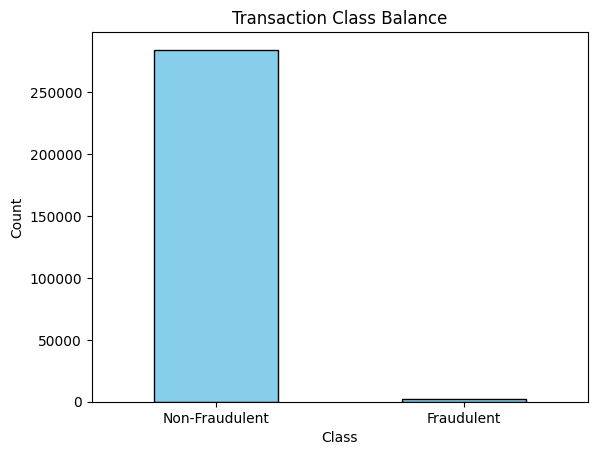

In [34]:
# We check the Class balance between Fraudulent and Non Fraudulent transactions
print(df["Class"].value_counts())
df["Class"].value_counts().plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Transaction Class Balance")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["Non-Fraudulent", "Fraudulent"], rotation=0)
plt.show()

In [38]:
numeric_vars = [
    'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
    'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
    'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
    'Amount', 'hour', 'age', 'credit_score']
numeric_df = df[numeric_vars]

categoric_vars = ['ip_address', 'merchant_country', 'city', 'zip_code', 'merchant',
    'customer_country', 'month', 'time_of_day', 'device_type', 'os', 'browser']
categoric_df = df[categoric_vars]

binary_vars = ['is_foreign_tx', 'is_night_tx', 'is_high_amount',
    'day_of_week', 'is_weekend', 'is_mobile']
binary_df = df[binary_vars]

## Numeric Variables

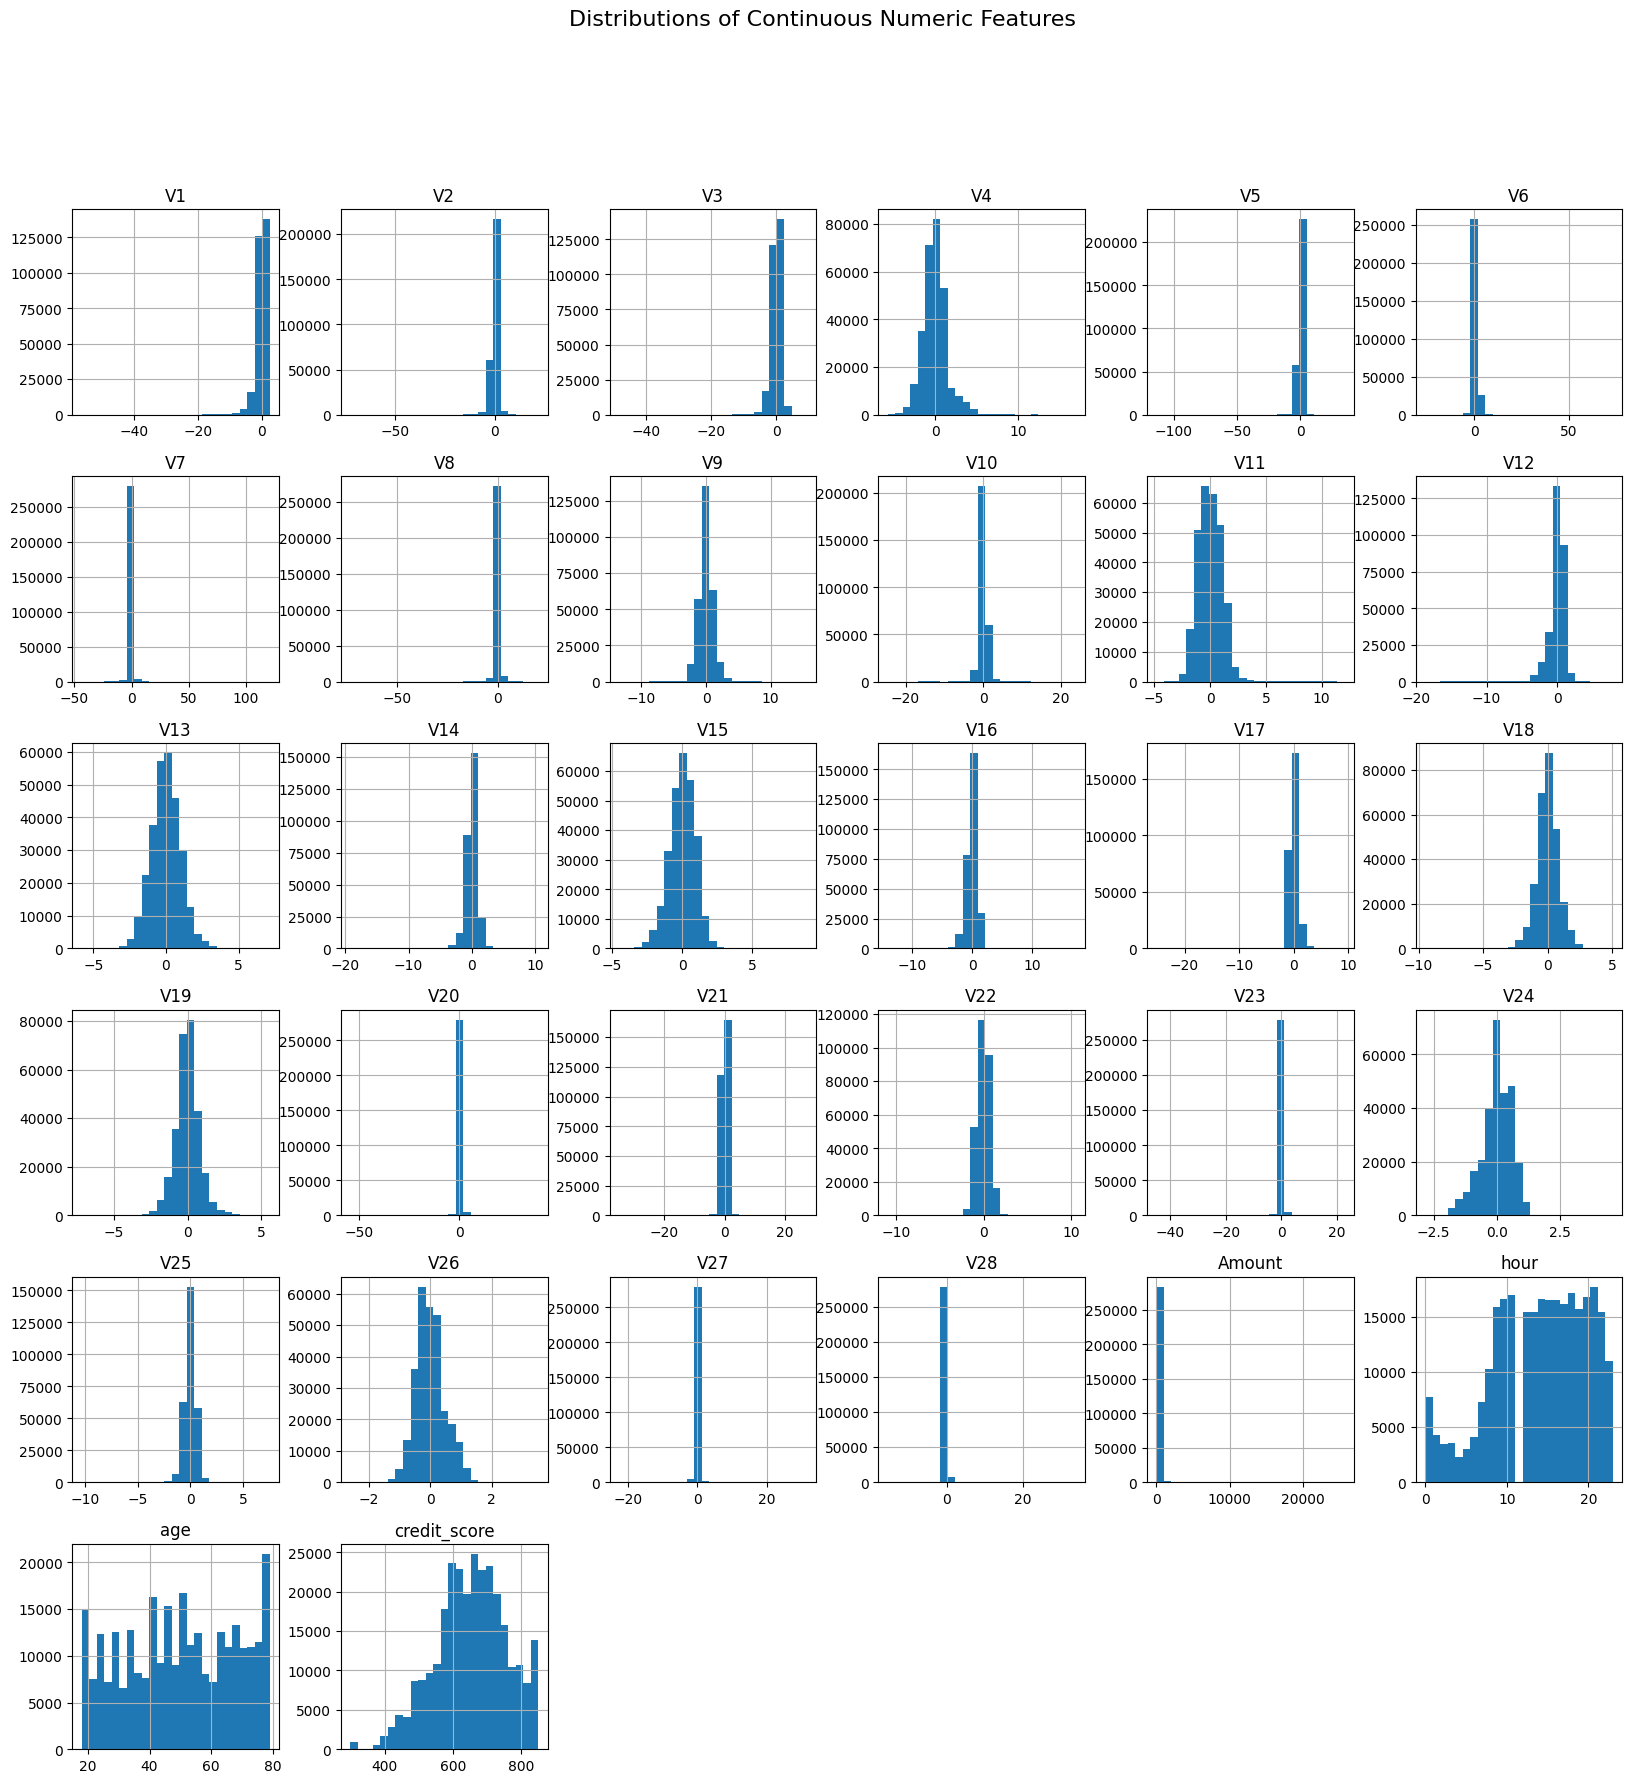

In [39]:
# Plot histograms for continuous numeric features
numeric_df.hist(figsize=(20, 20), bins=25)
plt.suptitle("Distributions of Continuous Numeric Features", fontsize=16)
plt.show()

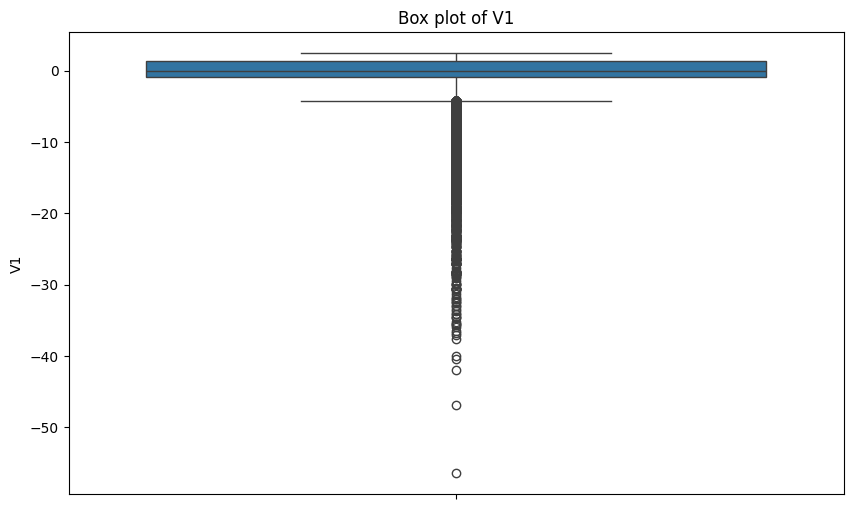

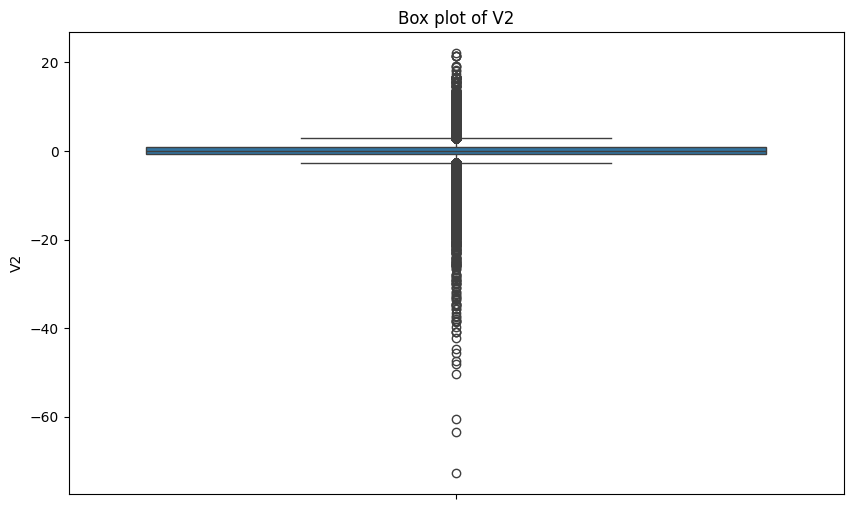

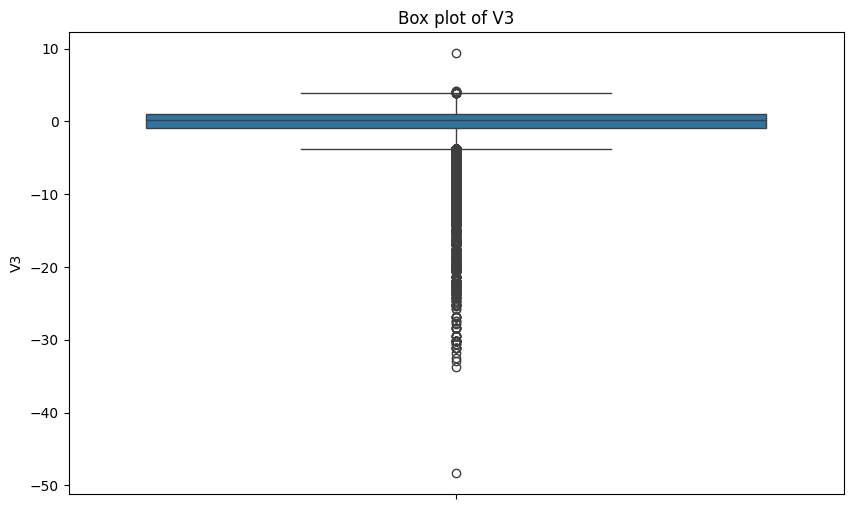

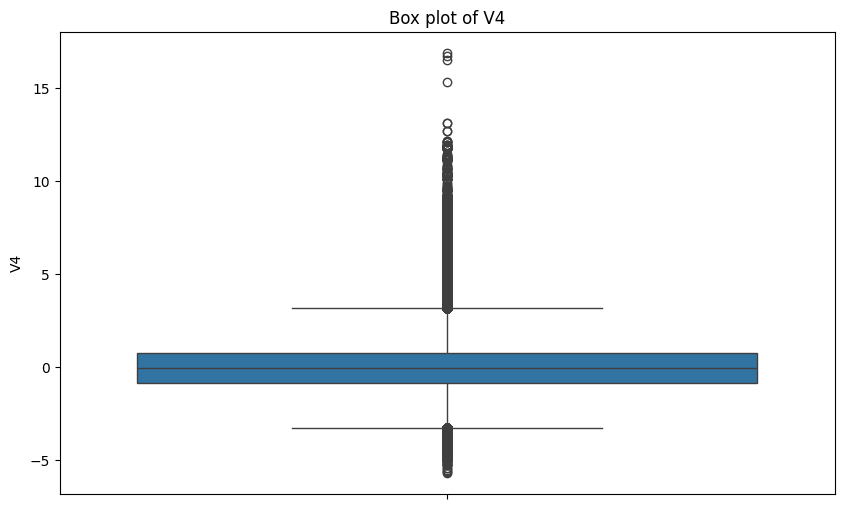

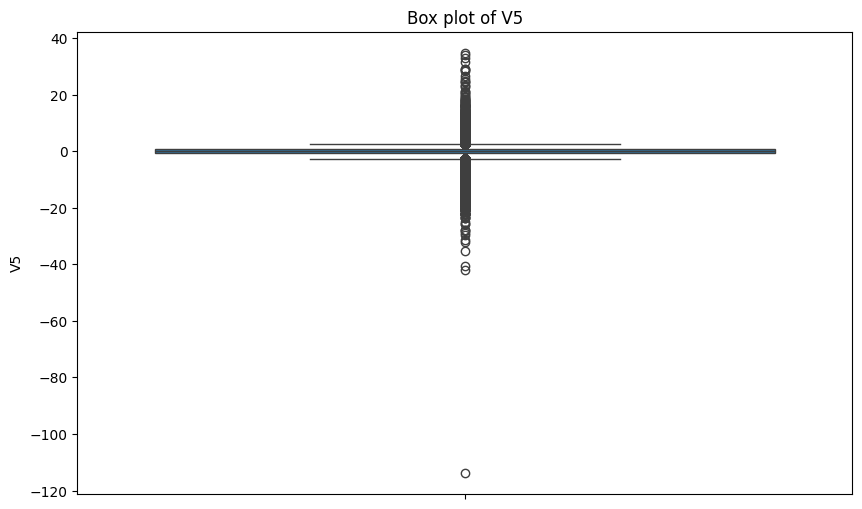

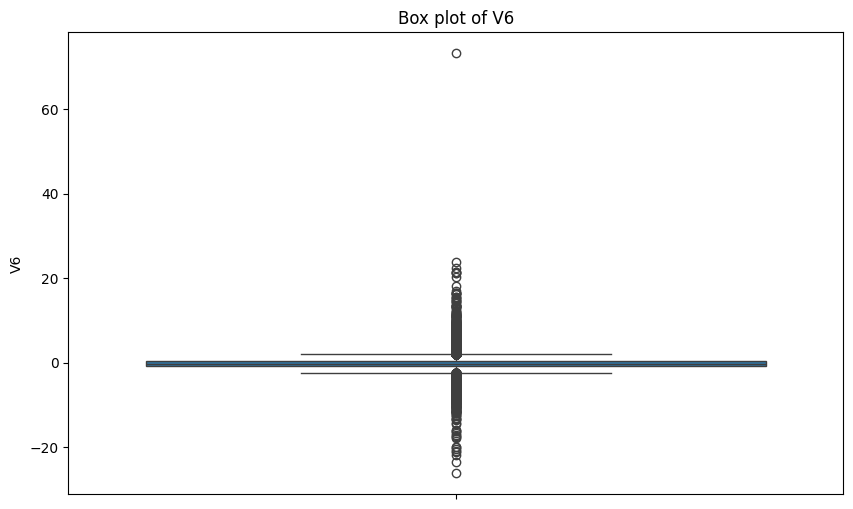

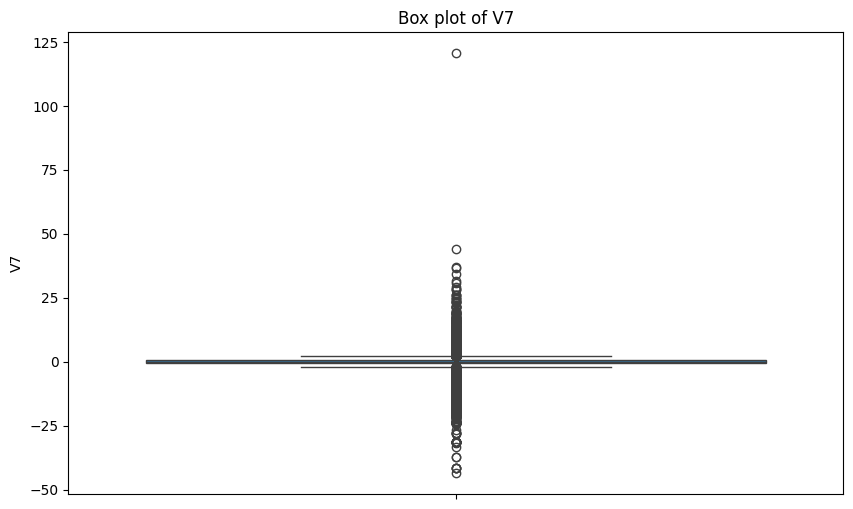

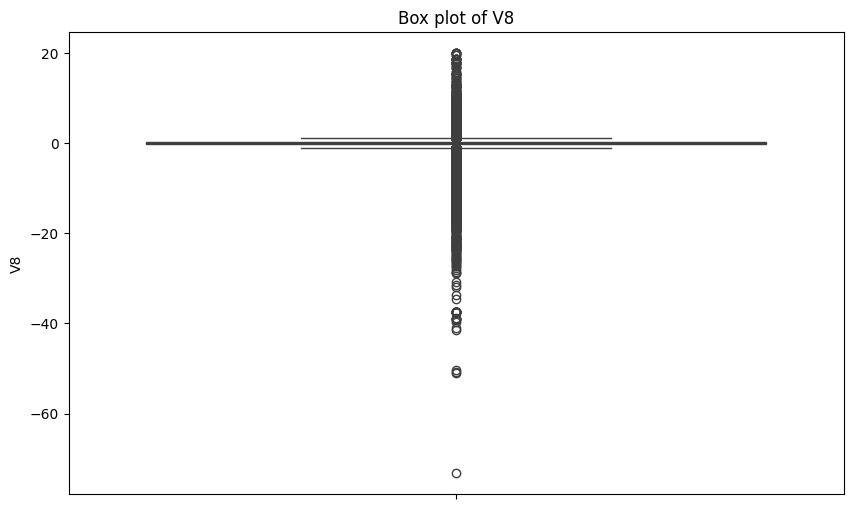

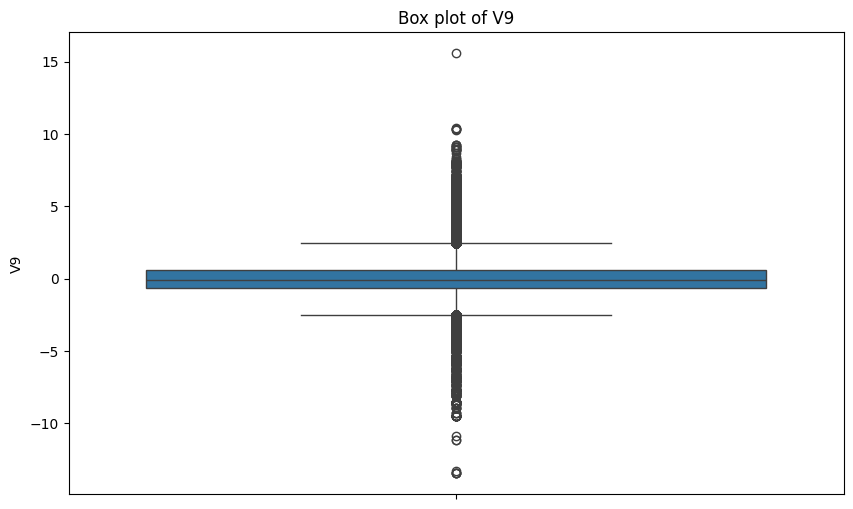

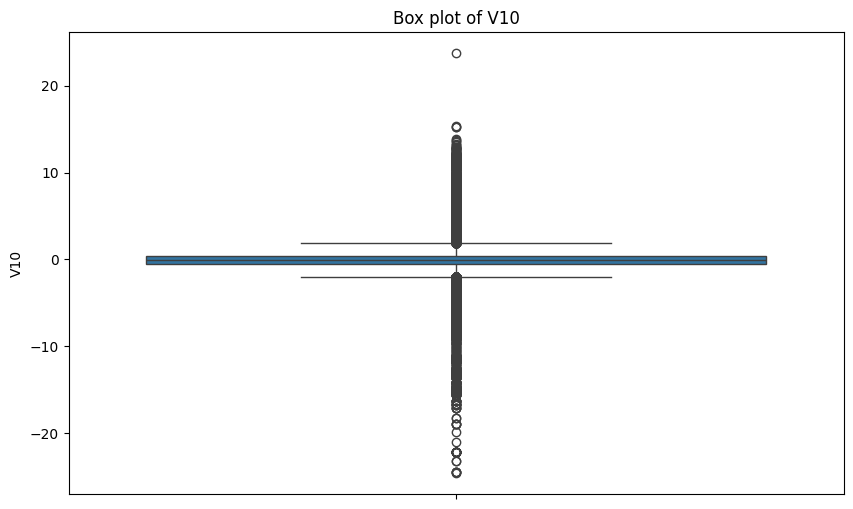

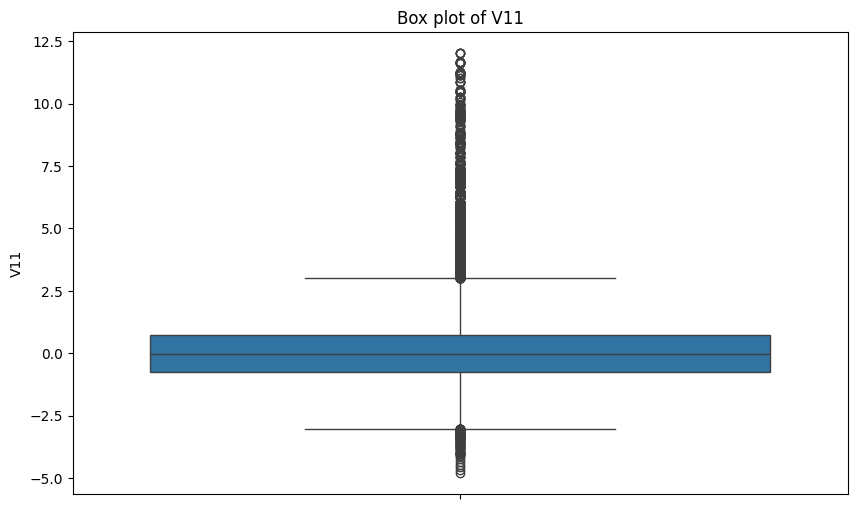

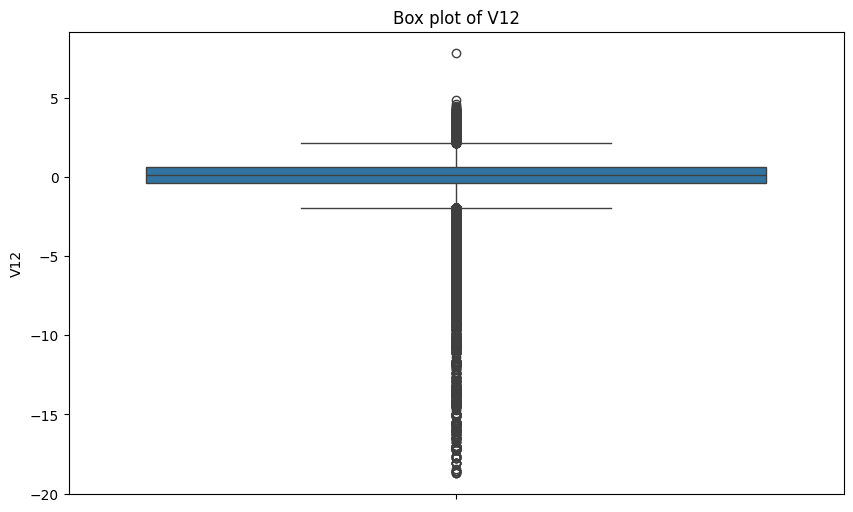

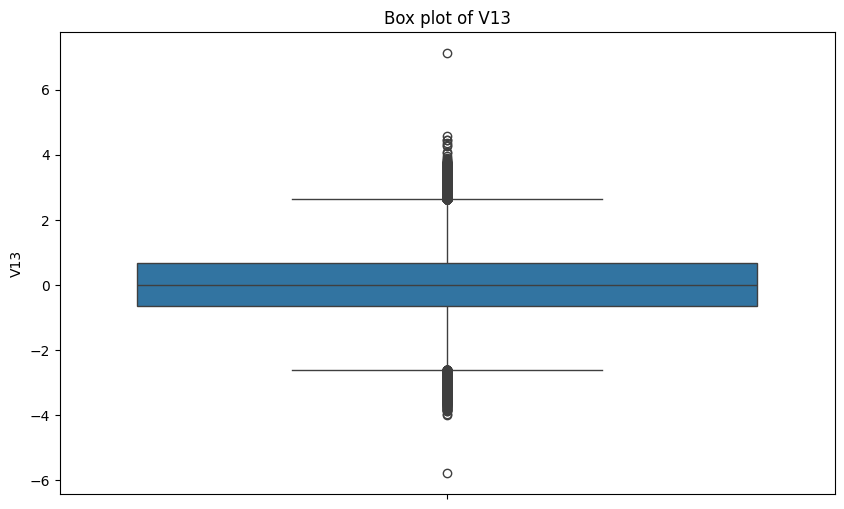

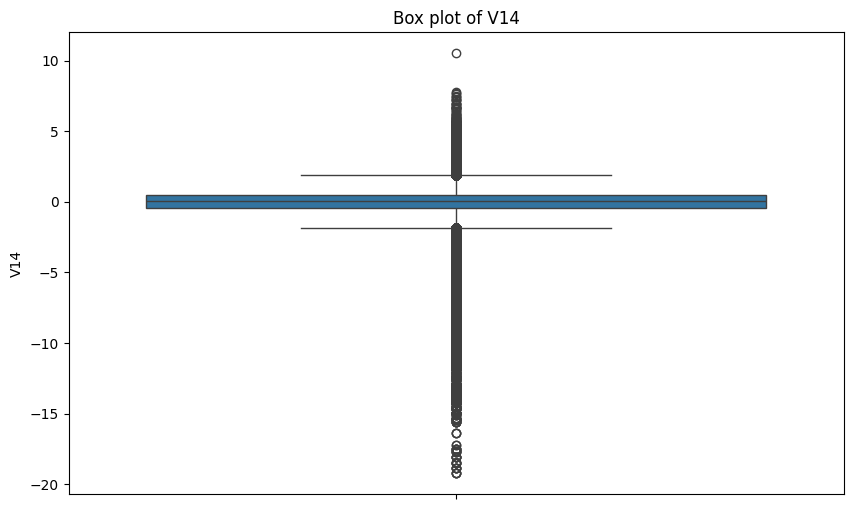

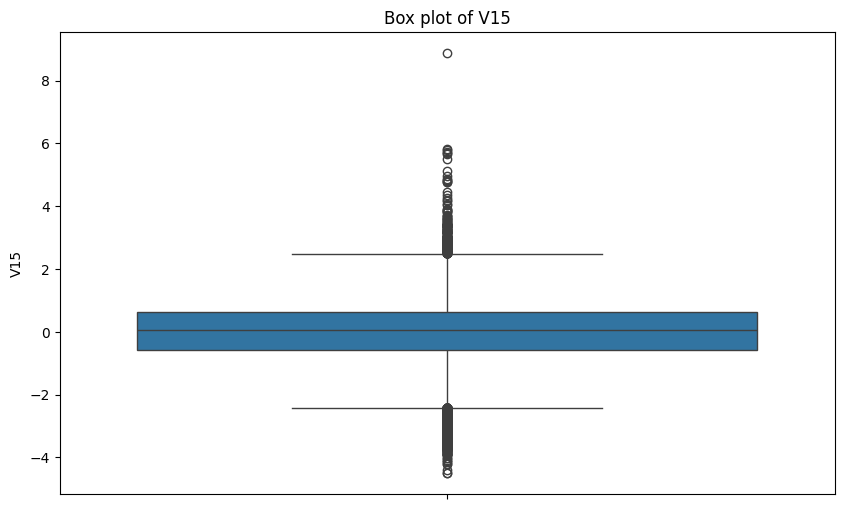

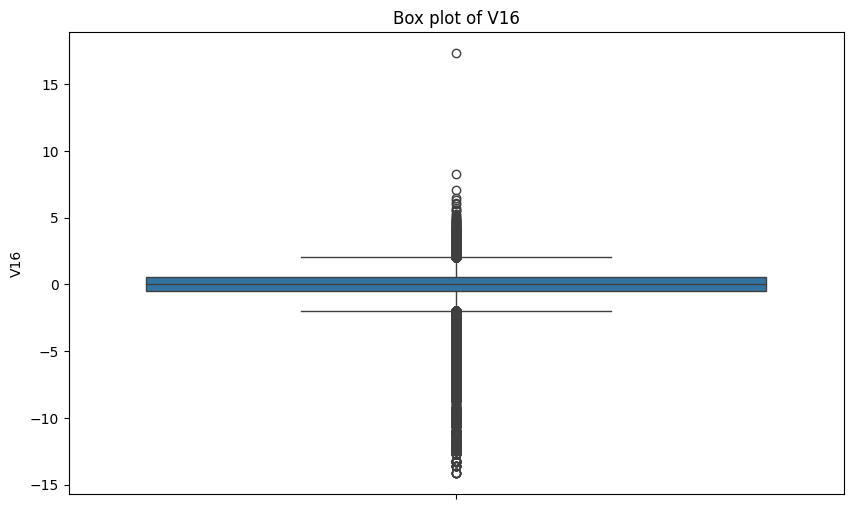

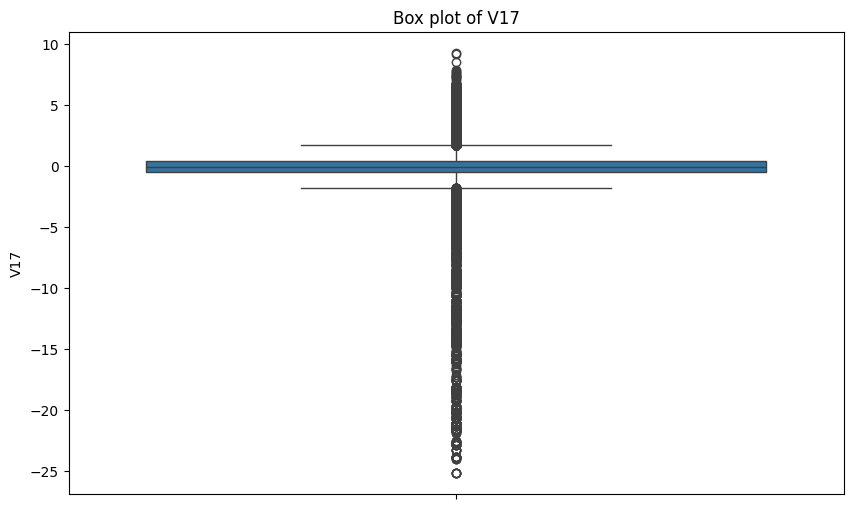

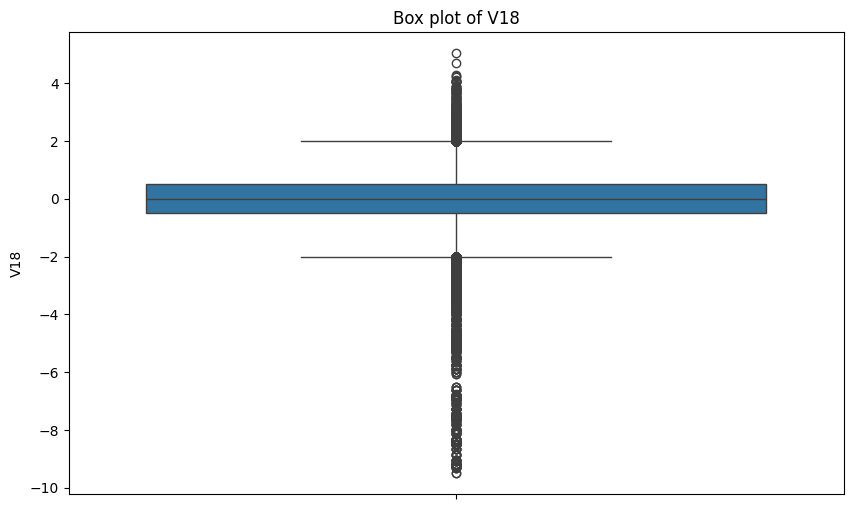

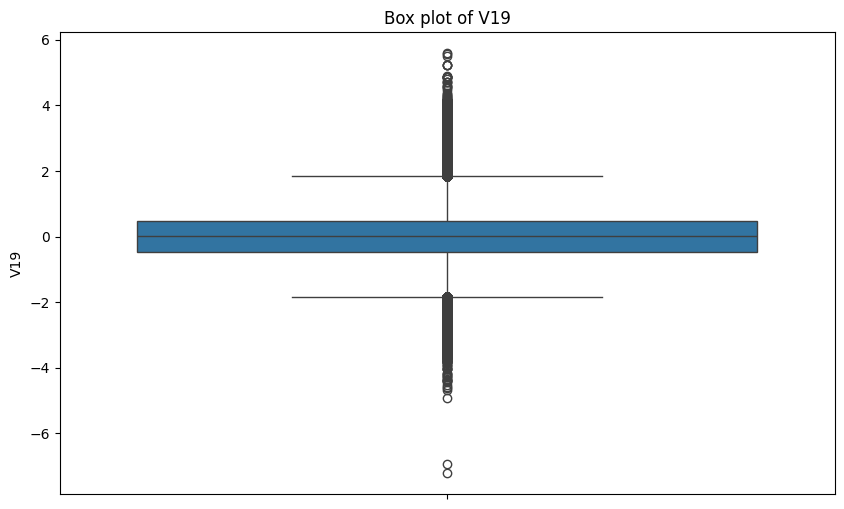

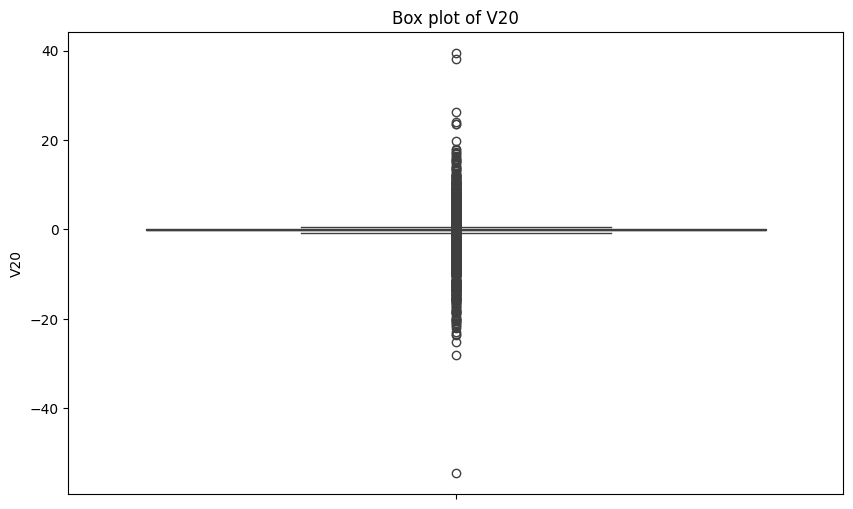

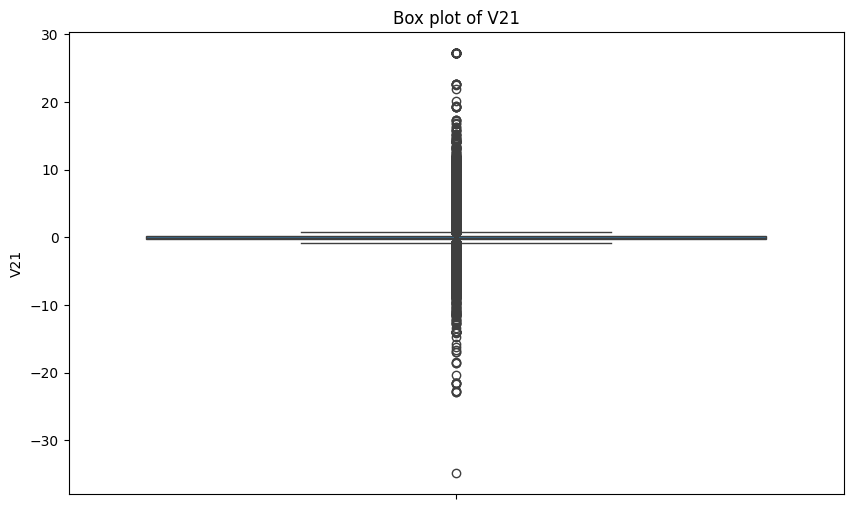

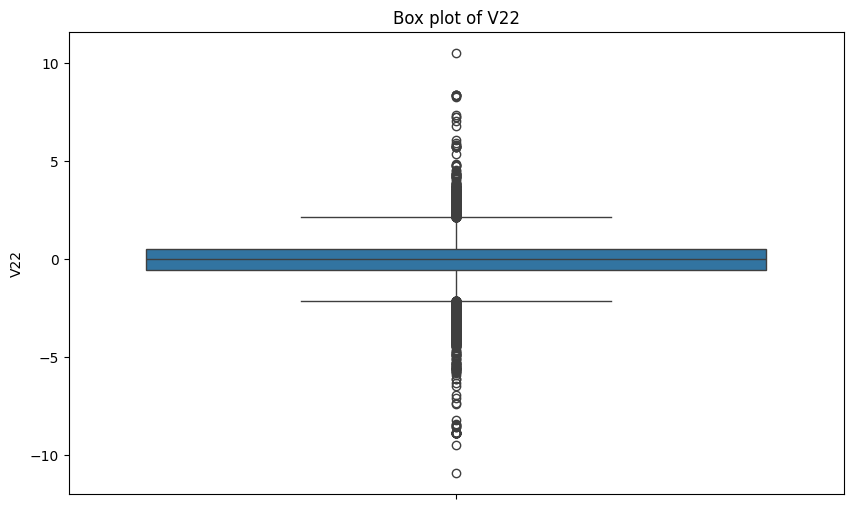

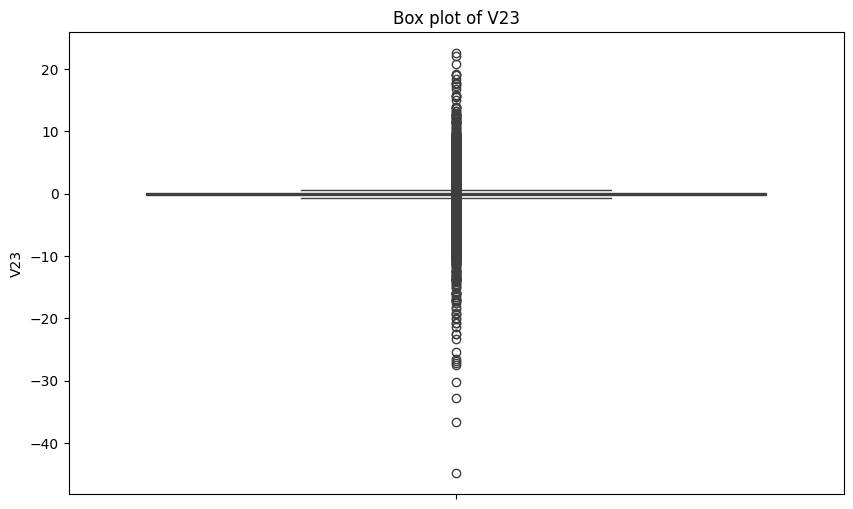

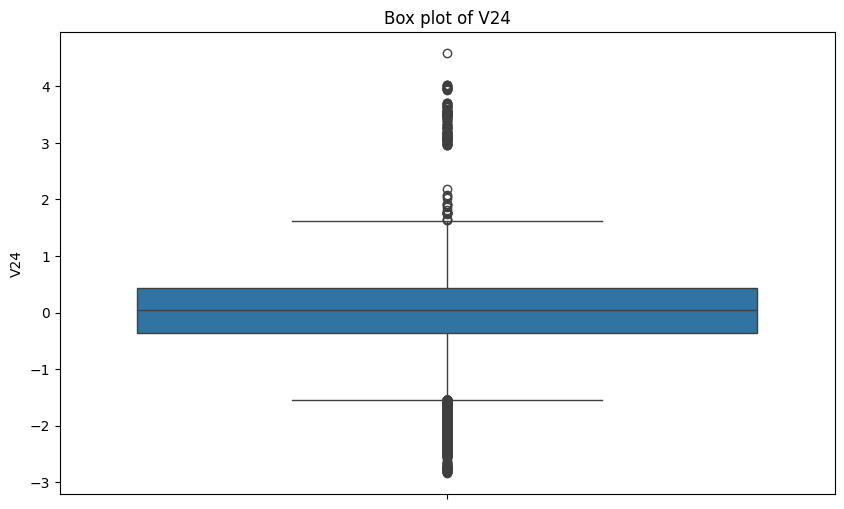

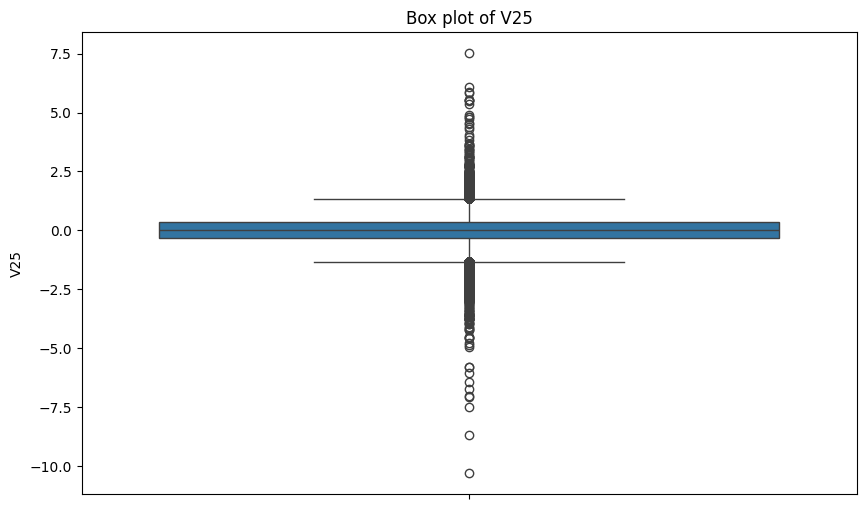

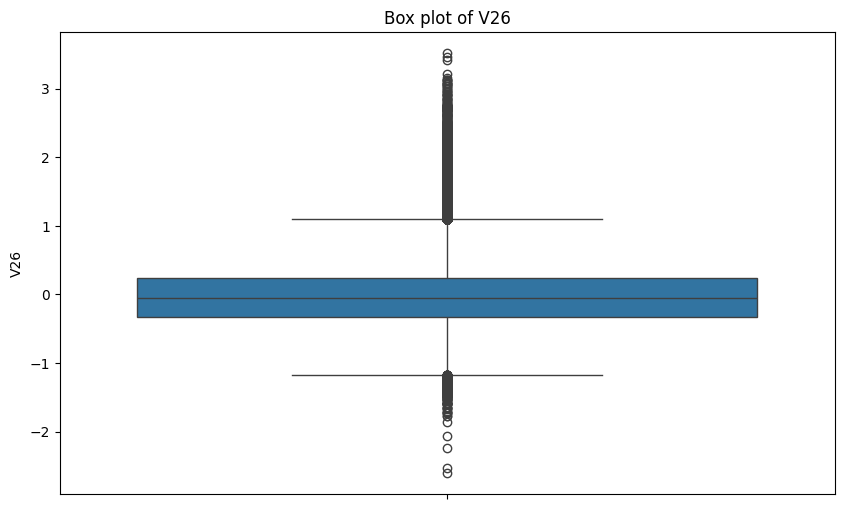

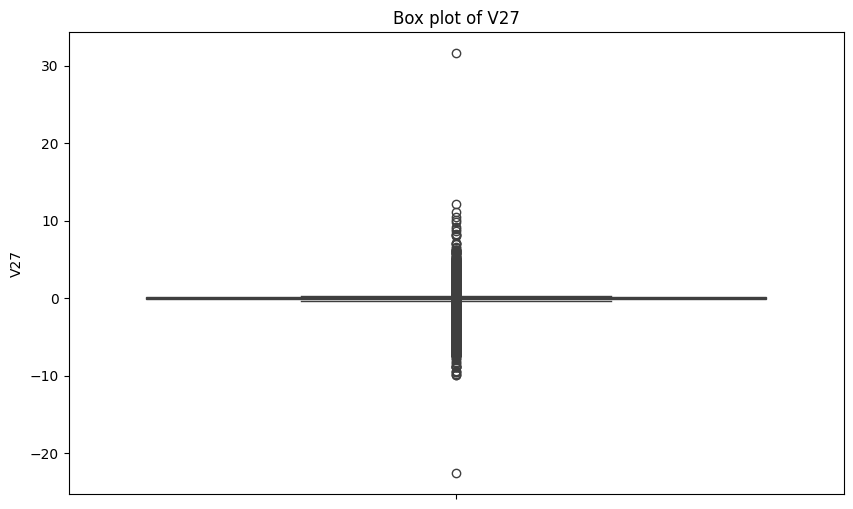

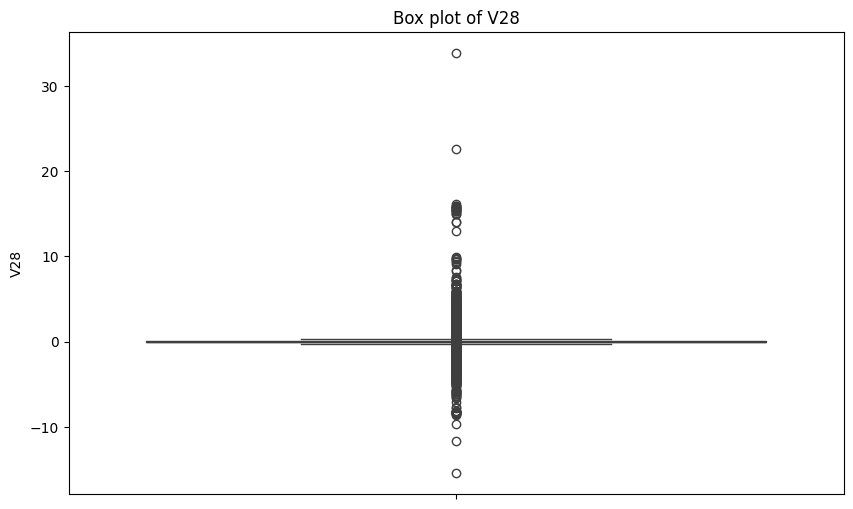

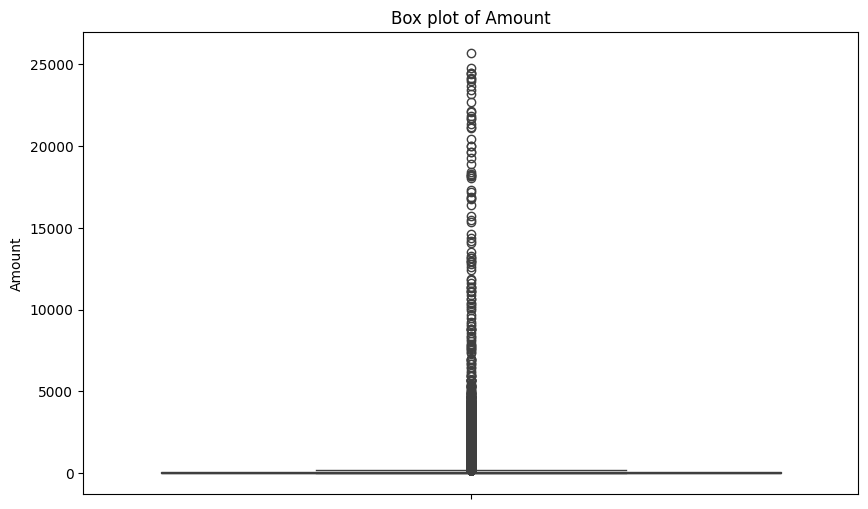

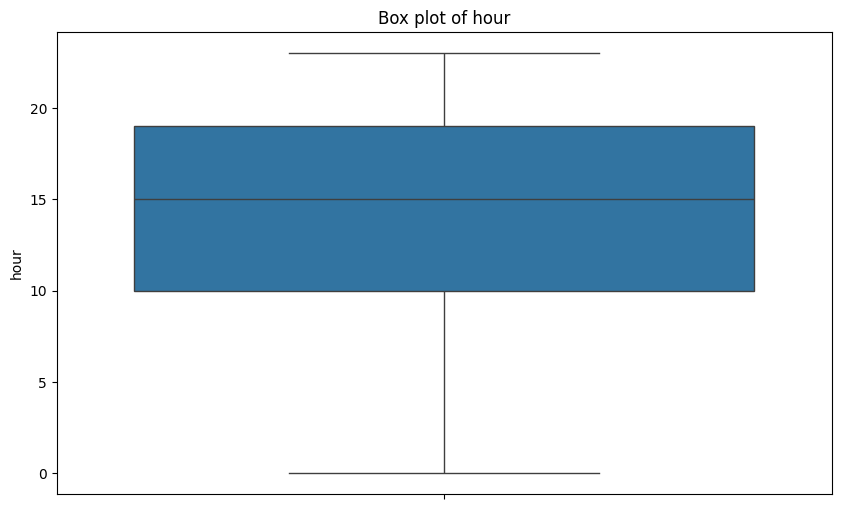

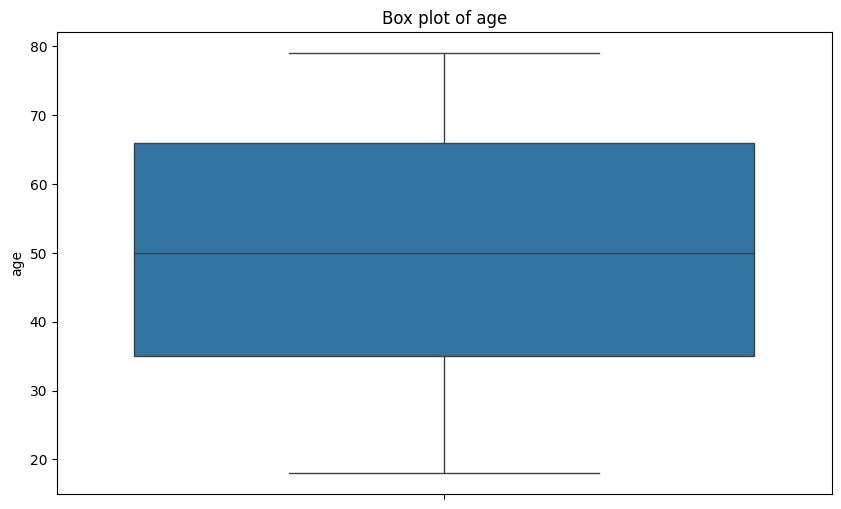

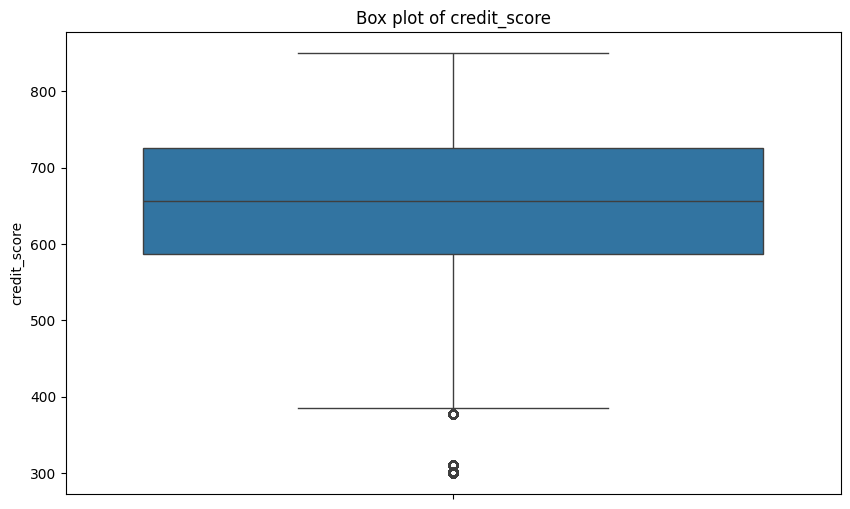

In [40]:
for col in numeric_df:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, y=col)
    plt.title(f'Box plot of {col}')
    plt.ylabel(col)
    plt.show()


Analysis for column: V1

Descriptive statistics:


,V1
count,286315.000000
mean,-0.024166
std,2.033031
min,-56.407510
25%,-0.929272
50%,0.009518
75%,1.313364
max,2.454930


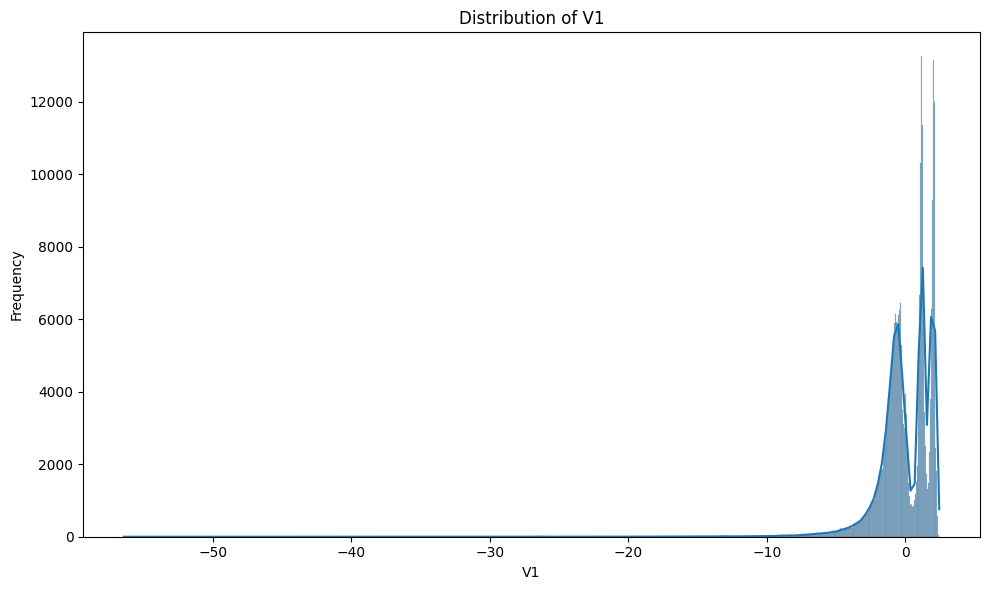

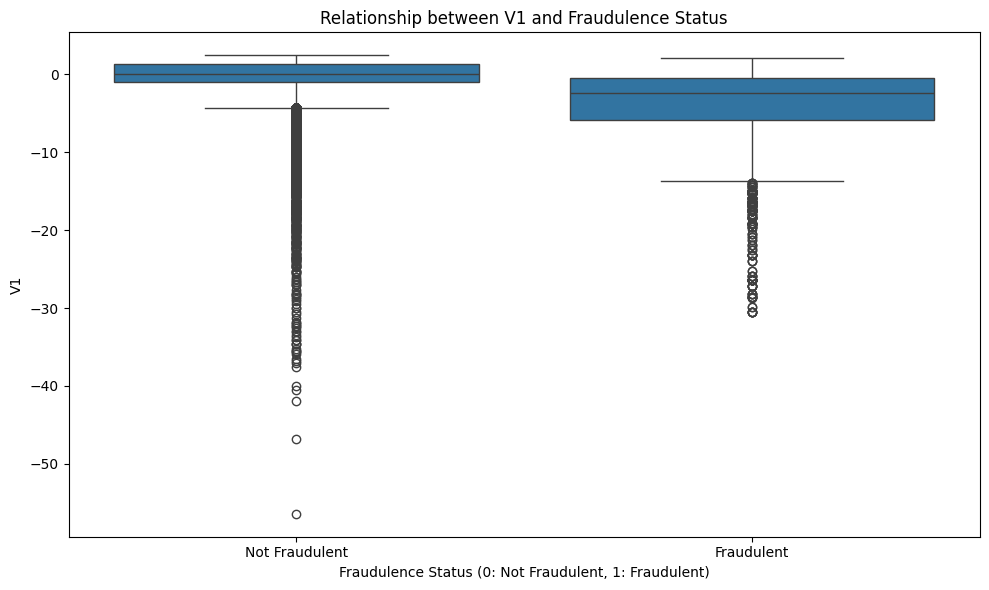


Analysis for column: V2

Descriptive statistics:


,V2
count,286315.000000
mean,0.018155
std,1.691744
min,-72.715728
25%,-0.595493
50%,0.070189
75%,0.813354
max,22.057729


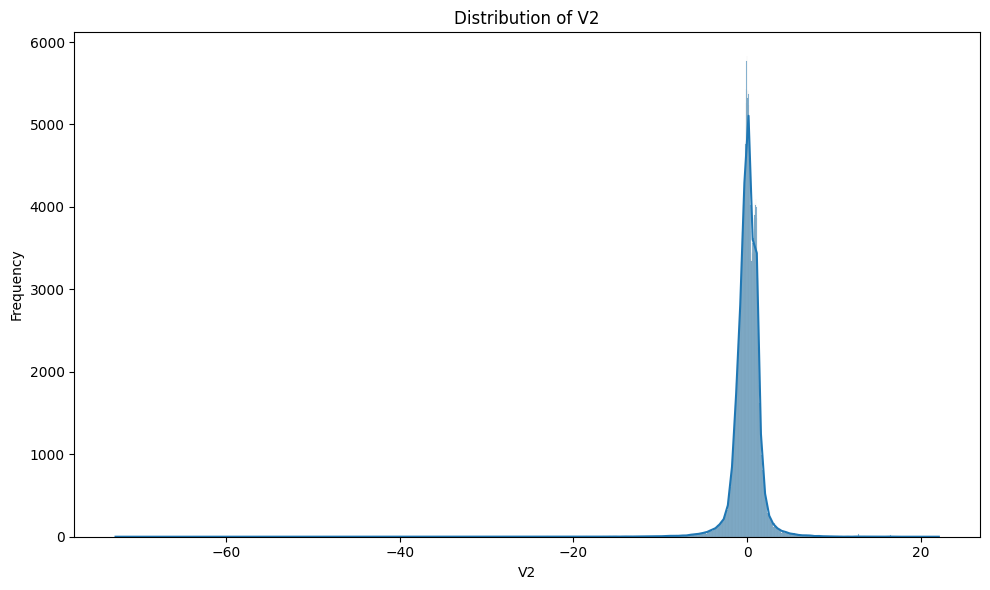

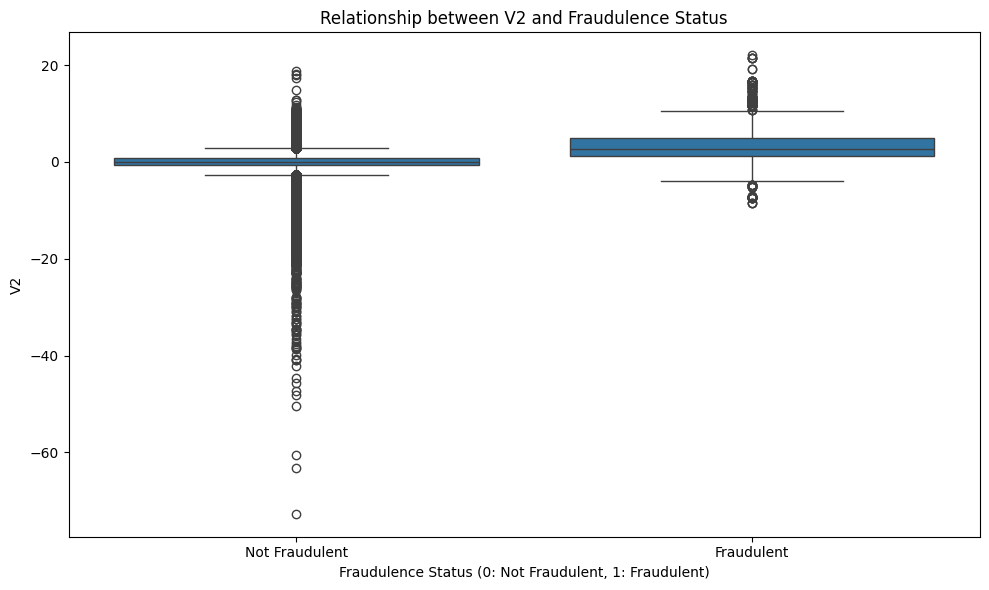


Analysis for column: V3

Descriptive statistics:


,V3
count,286315.000000
mean,-0.035505
std,1.664057
min,-48.325589
25%,-0.907409
50%,0.172793
75%,1.023179
max,9.382558


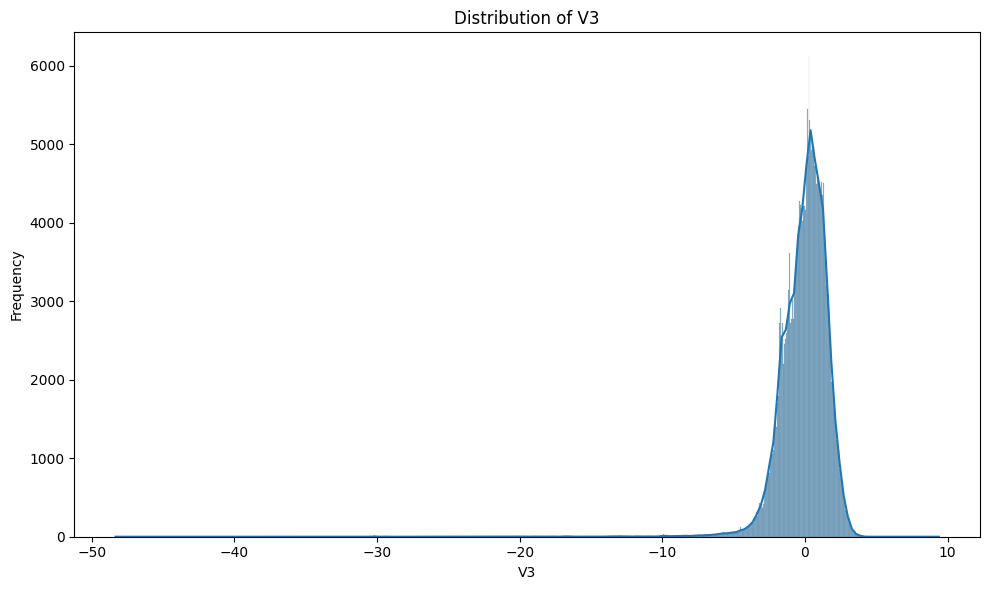

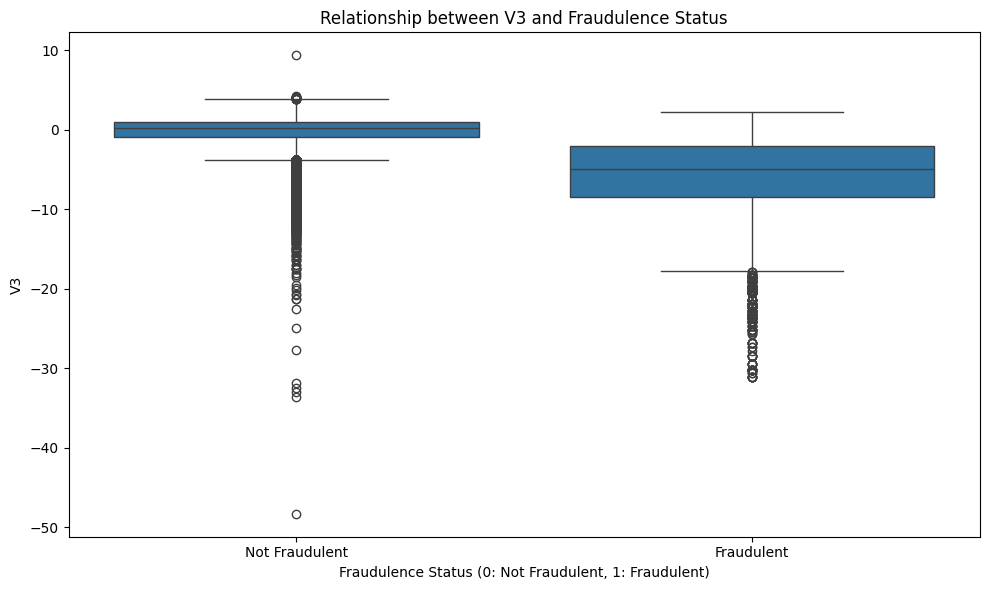


Analysis for column: V4

Descriptive statistics:


,V4
count,286315.000000
mean,0.023738
std,1.465026
min,-5.683171
25%,-0.843786
50%,-0.011537
75%,0.759227
max,16.875344


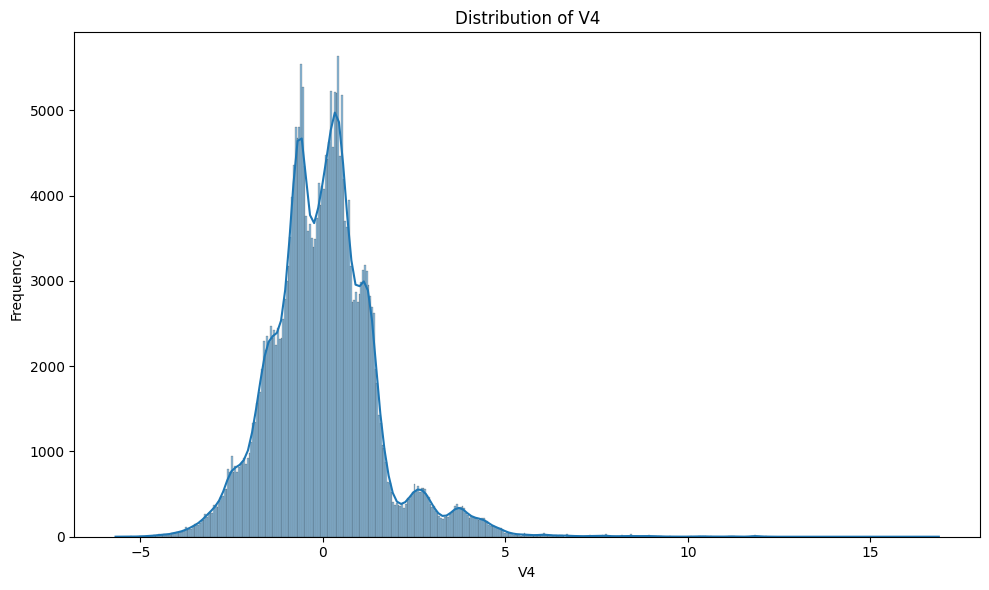

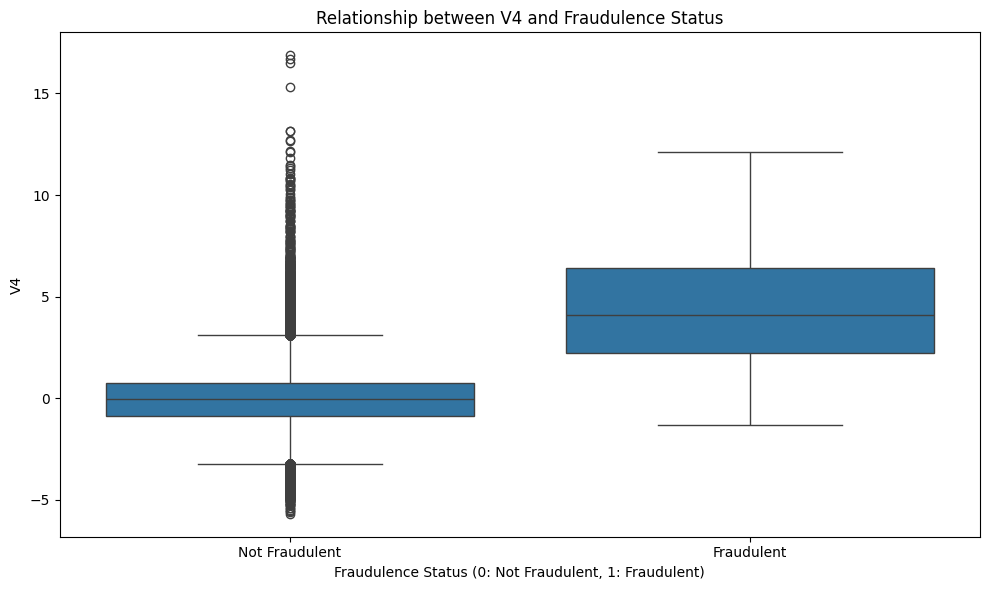


Analysis for column: V5

Descriptive statistics:


,V5
count,286315.000000
mean,-0.015496
std,1.440135
min,-113.743307
25%,-0.697608
50%,-0.057173
75%,0.610778
max,34.801666


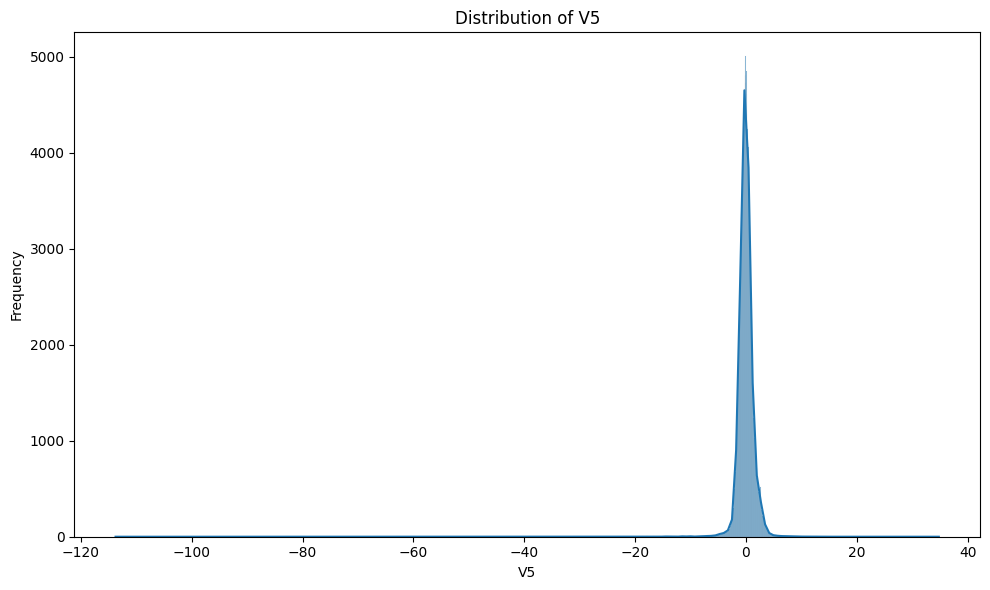

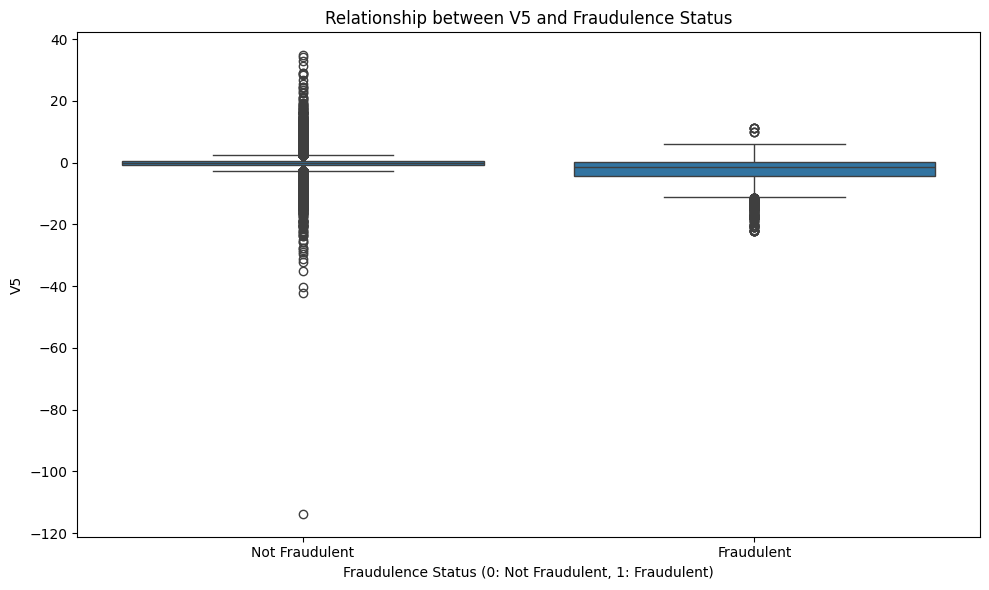


Analysis for column: V6

Descriptive statistics:


,V6
count,286315.000000
mean,-0.006939
std,1.338852
min,-26.160506
25%,-0.772949
50%,-0.277219
75%,0.395847
max,73.301626


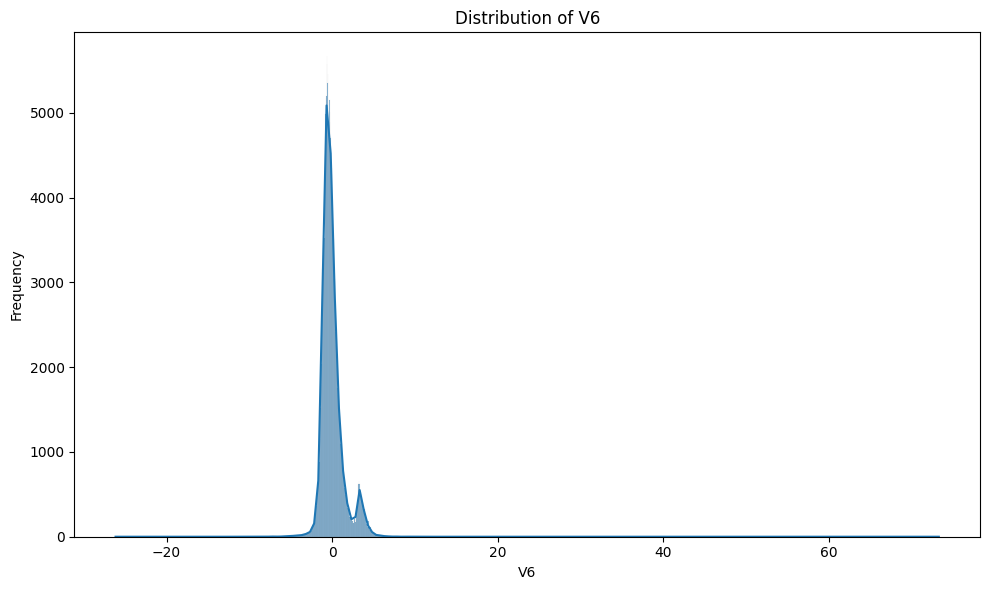

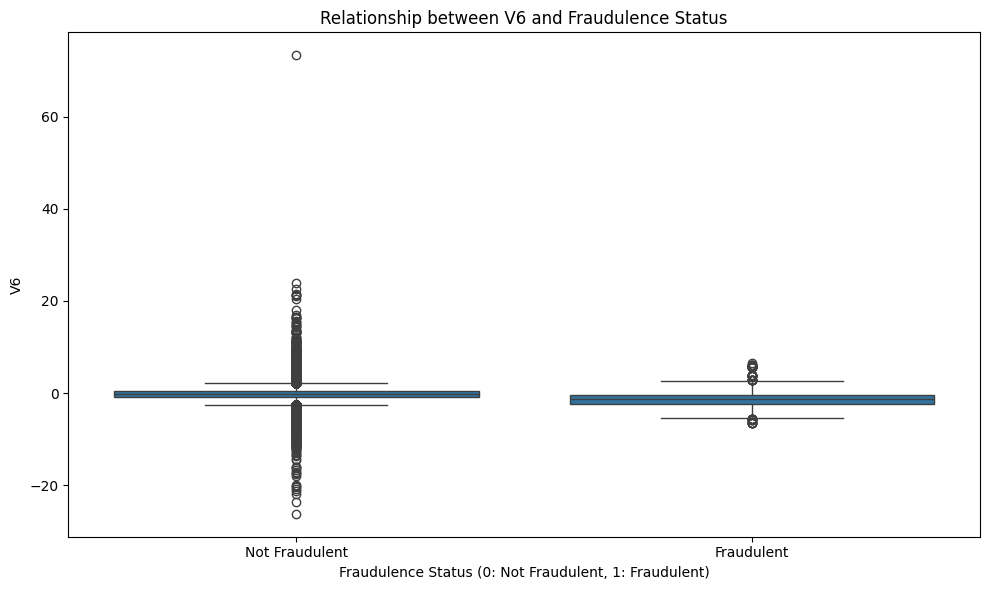


Analysis for column: V7

Descriptive statistics:


,V7
count,286315.000000
mean,-0.028154
std,1.383856
min,-43.557242
25%,-0.560981
50%,0.037005
75%,0.568421
max,120.589494


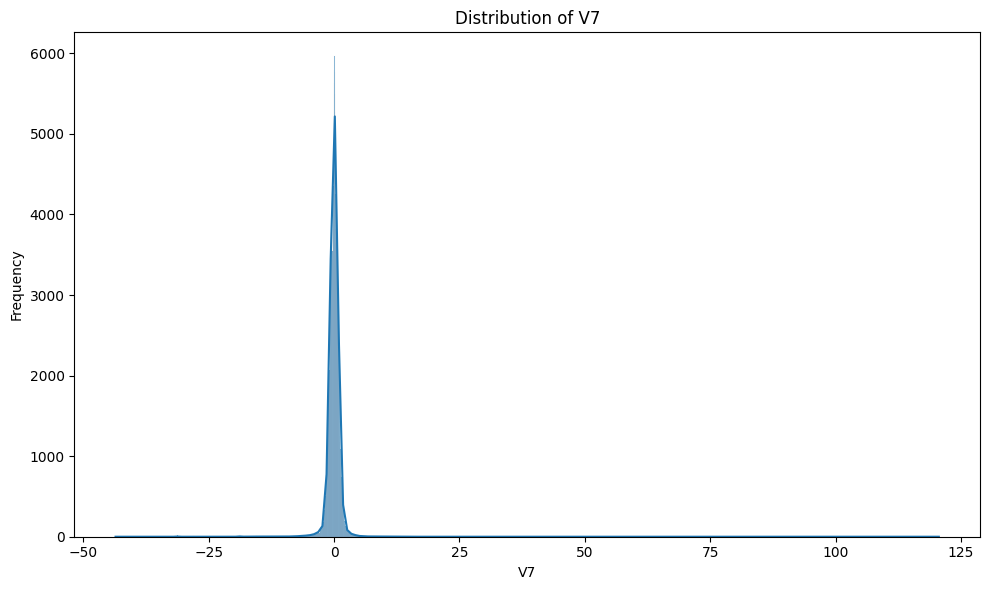

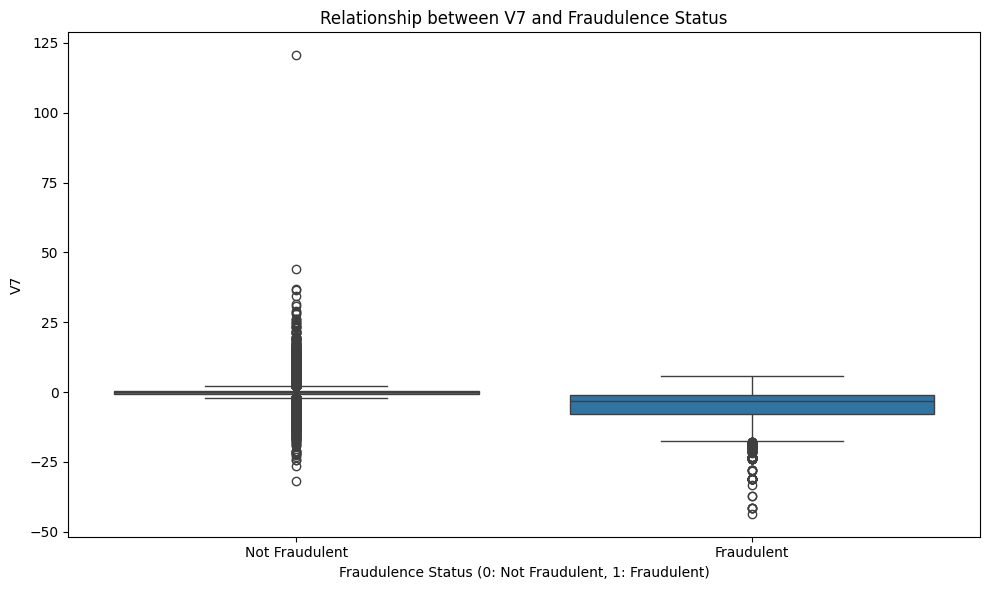


Analysis for column: V8

Descriptive statistics:


,V8
count,286315.000000
mean,0.001809
std,1.285448
min,-73.216718
25%,-0.208711
50%,0.023150
75%,0.330601
max,20.007208


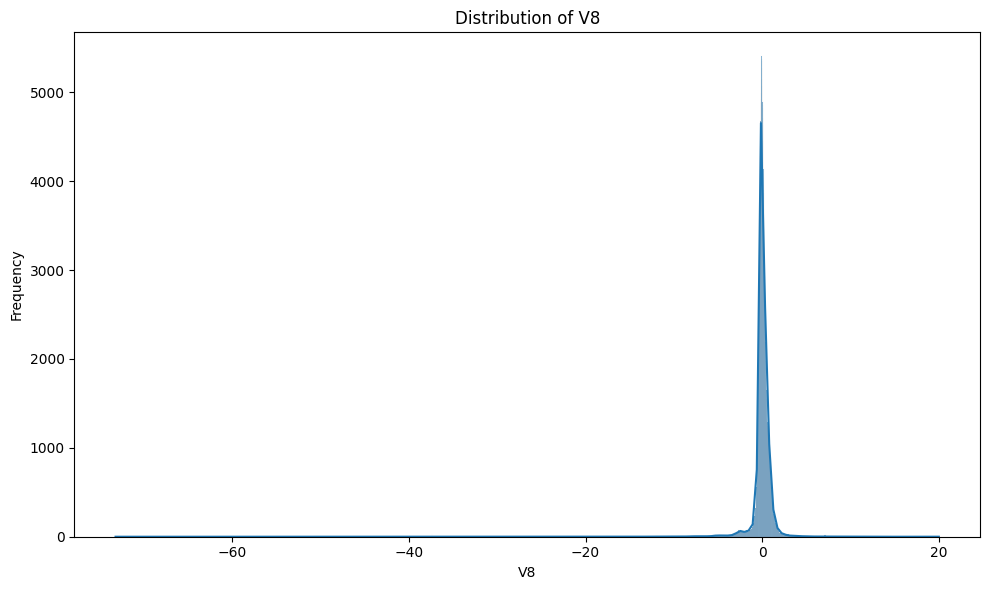

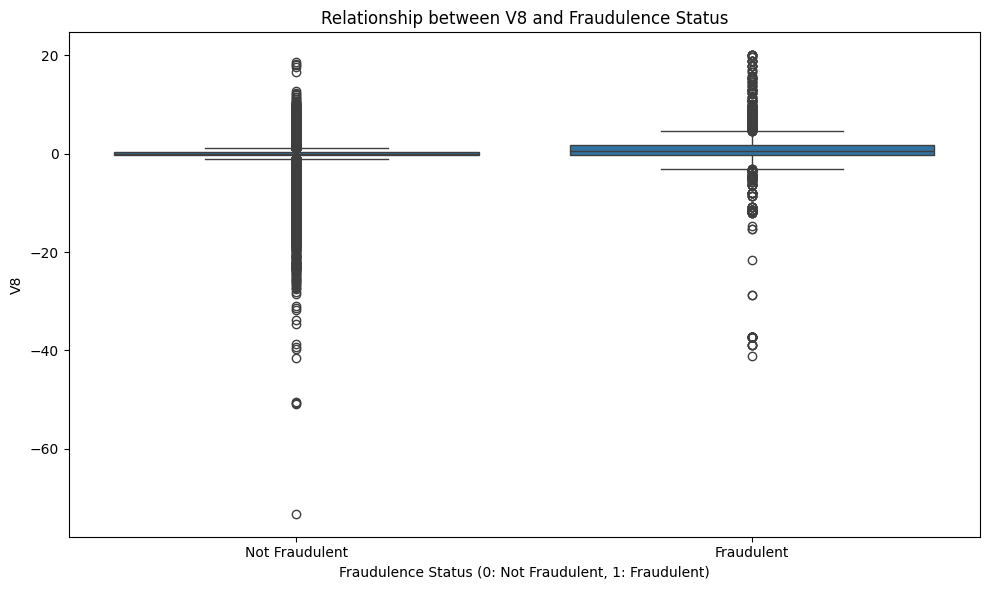


Analysis for column: V9

Descriptive statistics:


,V9
count,286315.000000
mean,-0.013087
std,1.124924
min,-13.434066
25%,-0.651328
50%,-0.054419
75%,0.594028
max,15.594995


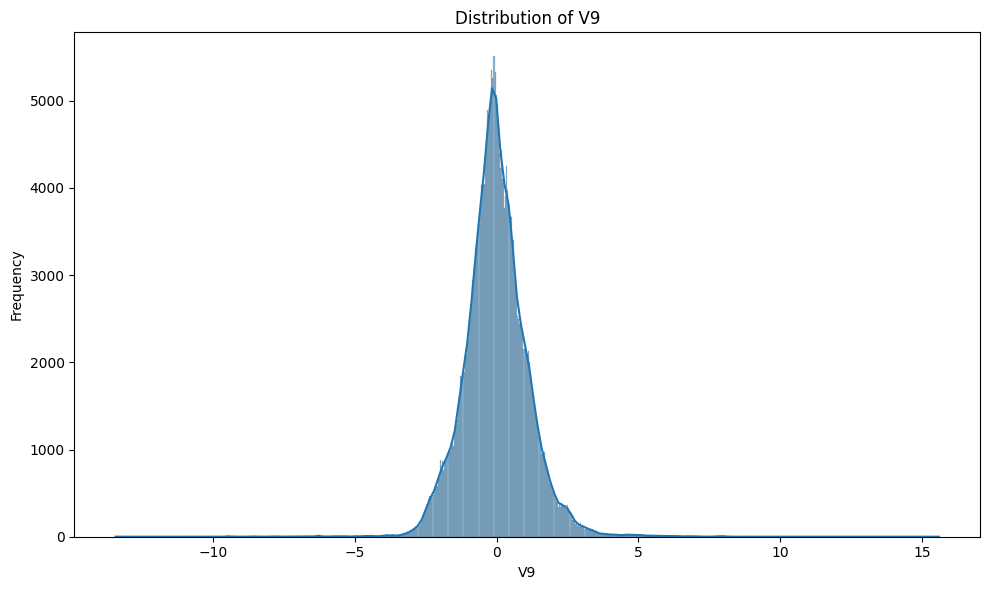

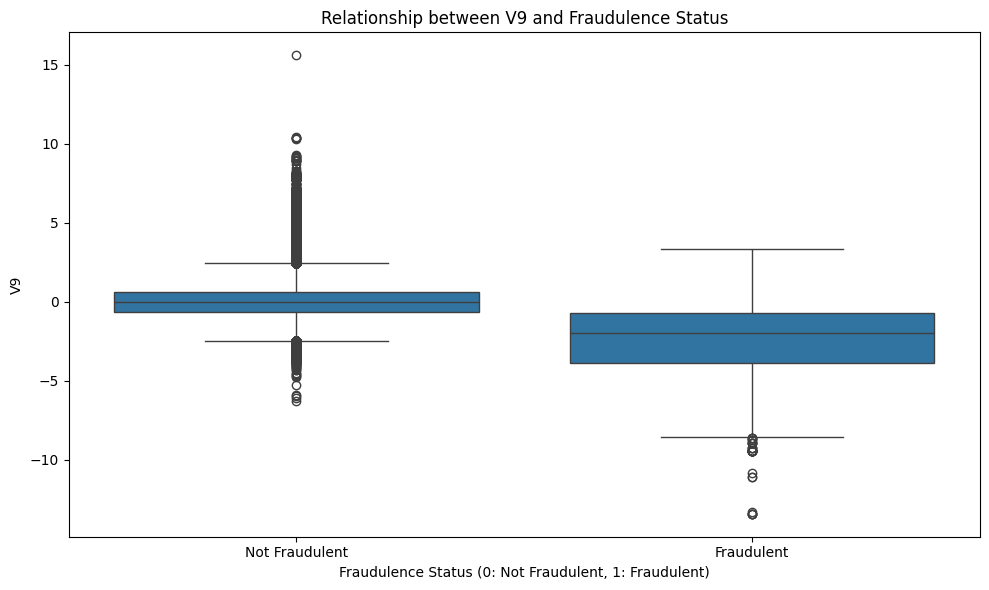


Analysis for column: V10

Descriptive statistics:


,V10
count,286315.000000
mean,-0.029173
std,1.209545
min,-24.588262
25%,-0.542040
50%,-0.096187
75%,0.449688
max,23.745136


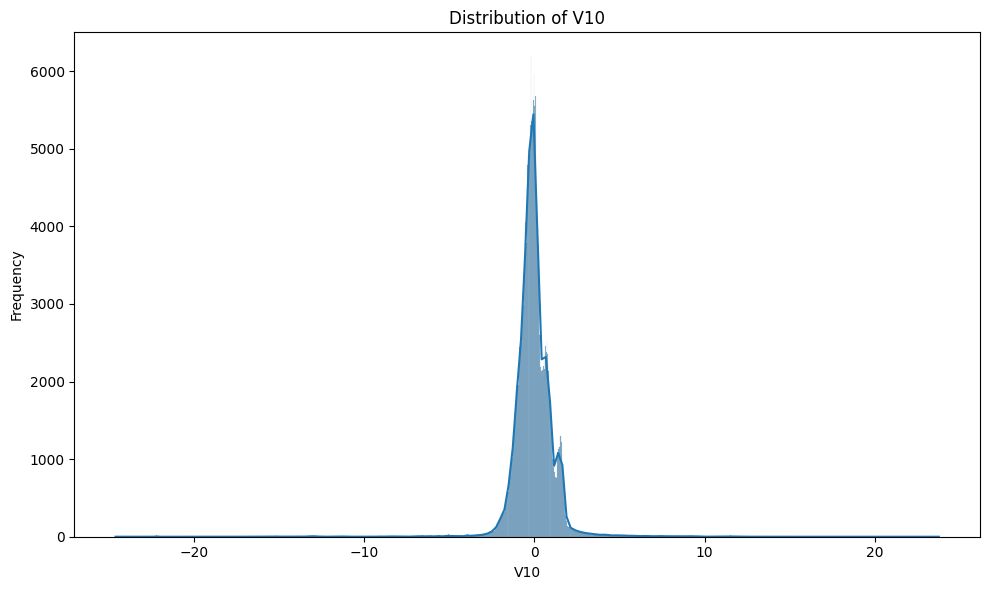

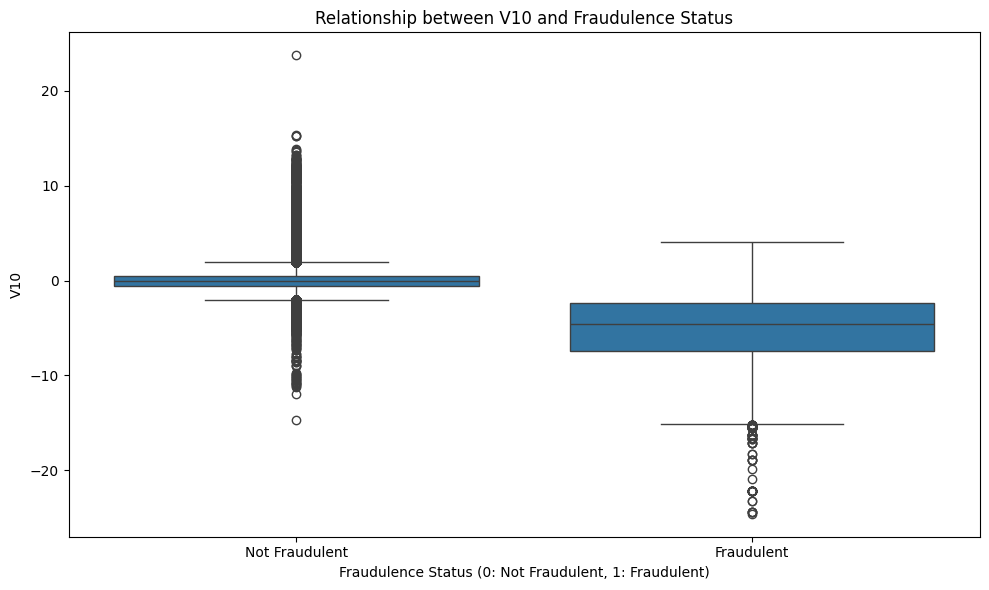


Analysis for column: V11

Descriptive statistics:


,V11
count,286315.000000
mean,0.020162
std,1.073409
min,-4.797473
25%,-0.759153
50%,-0.026350
75%,0.750812
max,12.018913


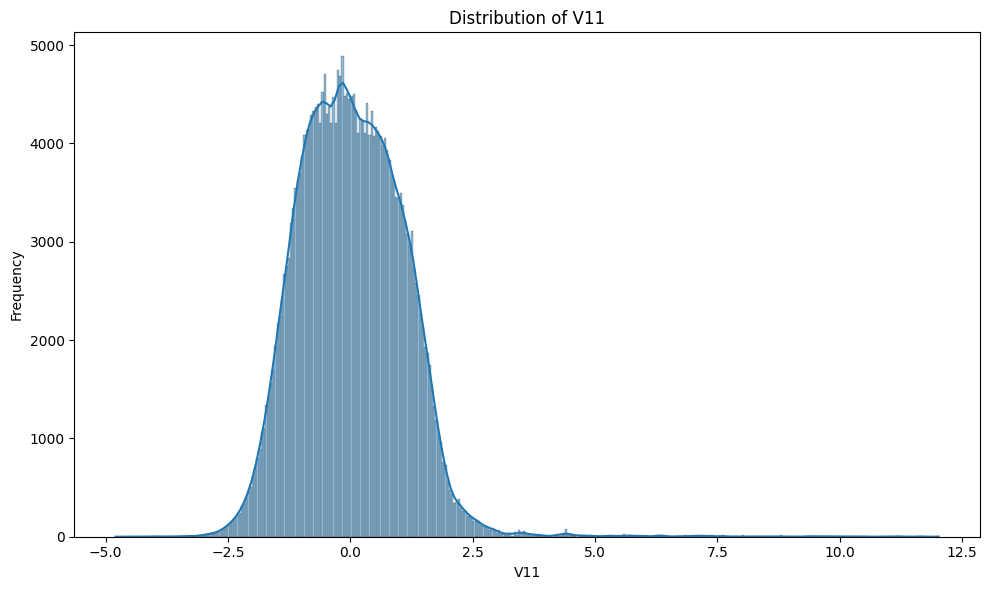

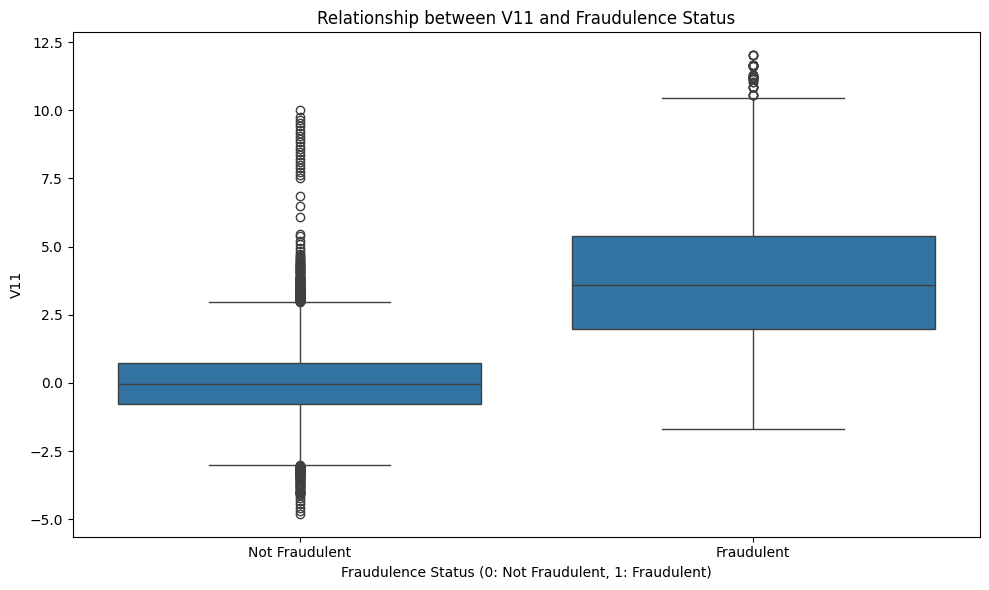


Analysis for column: V12

Descriptive statistics:


,V12
count,286315.000000
mean,-0.033073
std,1.147903
min,-18.683715
25%,-0.415203
50%,0.135297
75%,0.615625
max,7.848392


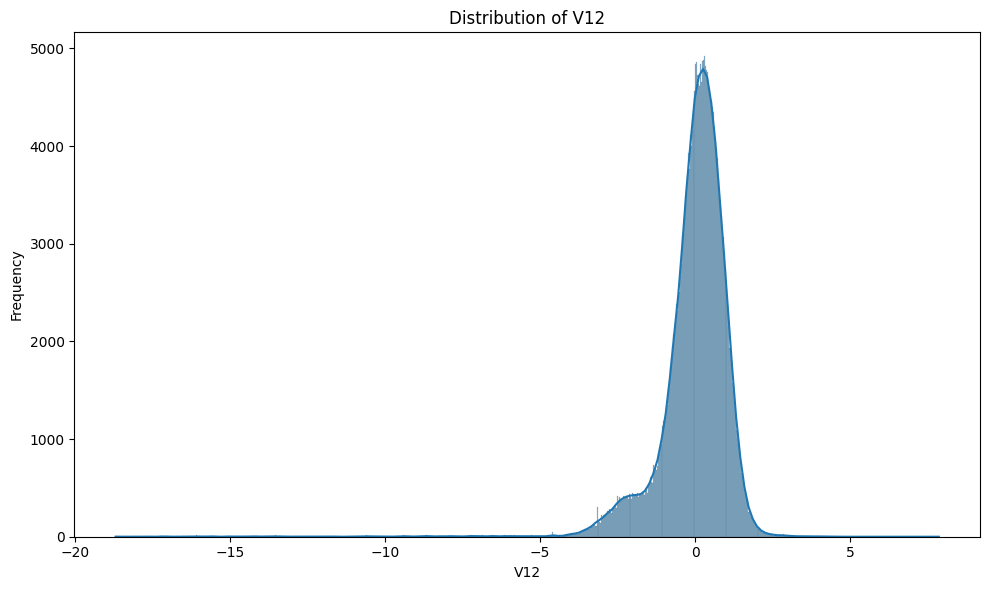

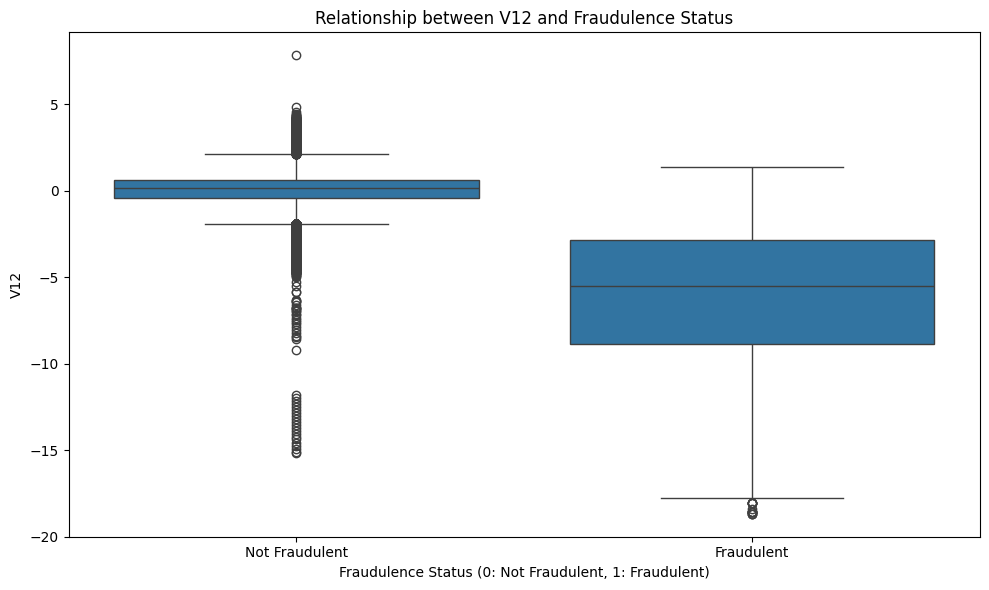


Analysis for column: V13

Descriptive statistics:


,V13
count,286315.000000
mean,-0.000300
std,0.996100
min,-5.791881
25%,-0.649853
50%,-0.013547
75%,0.663103
max,7.126883


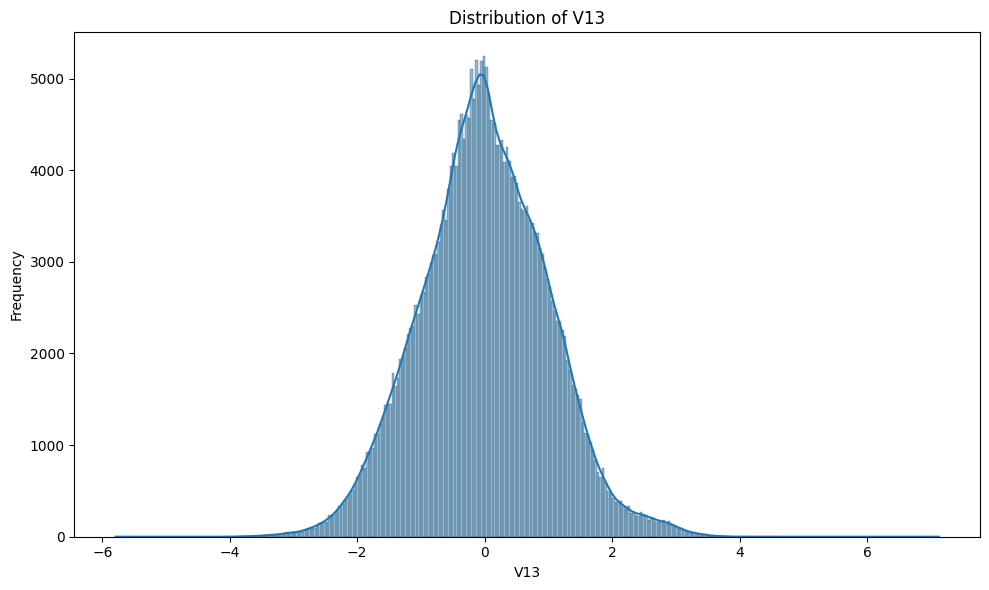

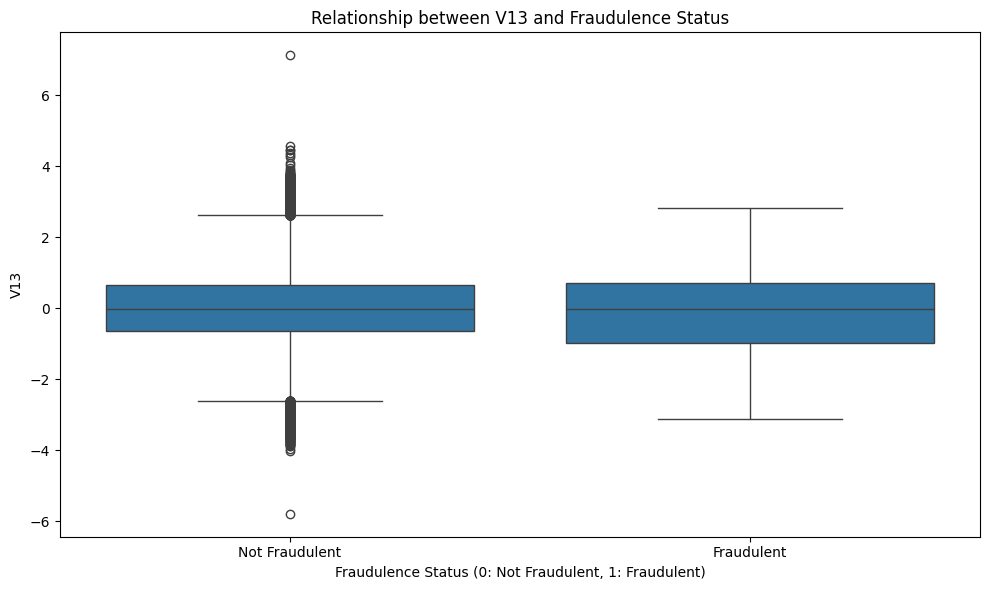


Analysis for column: V14

Descriptive statistics:


,V14
count,286315.000000
mean,-0.037293
std,1.130031
min,-19.214325
25%,-0.434084
50%,0.046862
75%,0.490590
max,10.526766


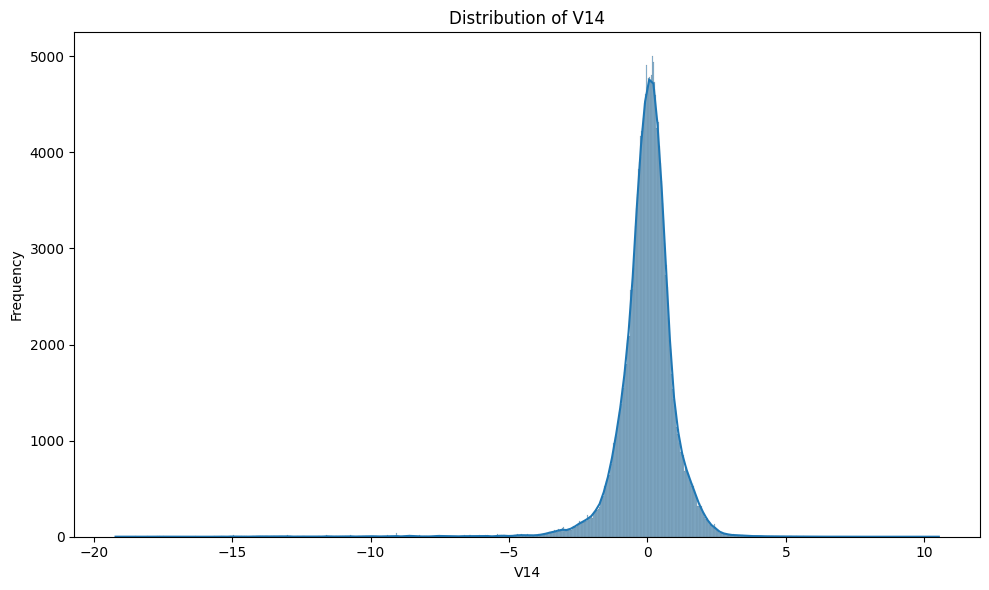

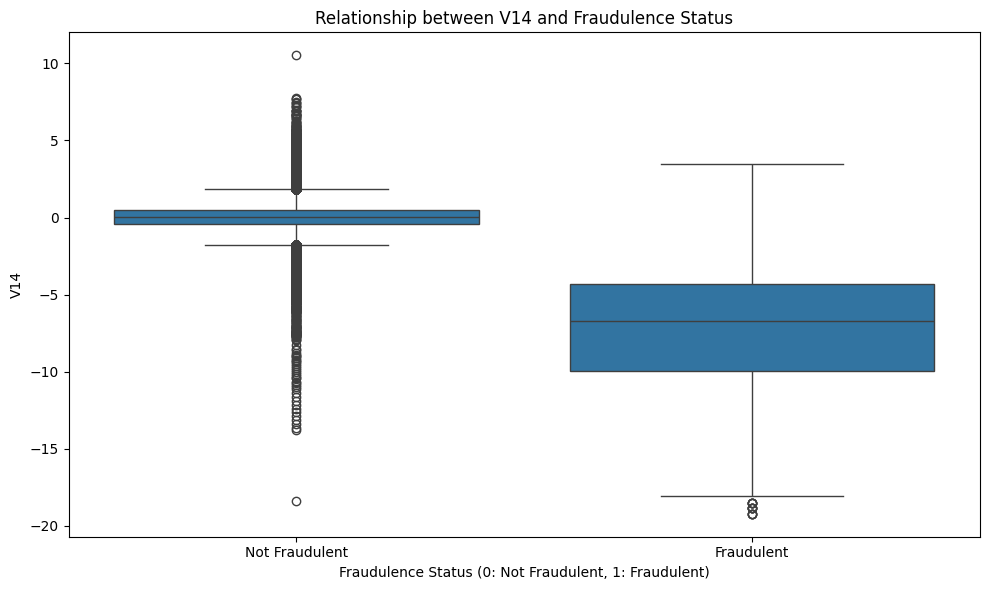


Analysis for column: V15

Descriptive statistics:


,V15
count,286315.000000
mean,-0.000430
std,0.915988
min,-4.498945
25%,-0.582884
50%,0.047537
75%,0.648497
max,8.877742


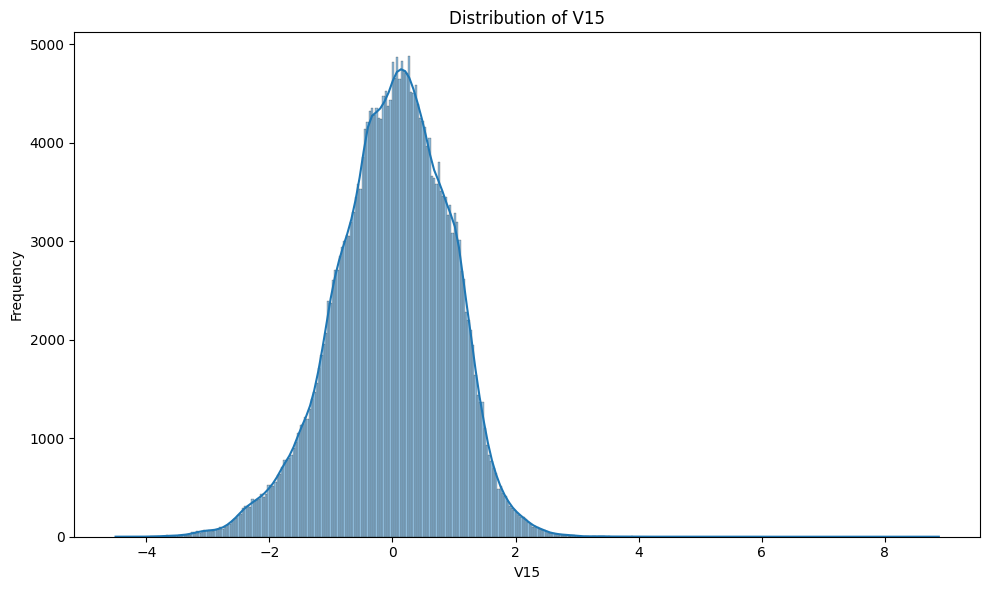

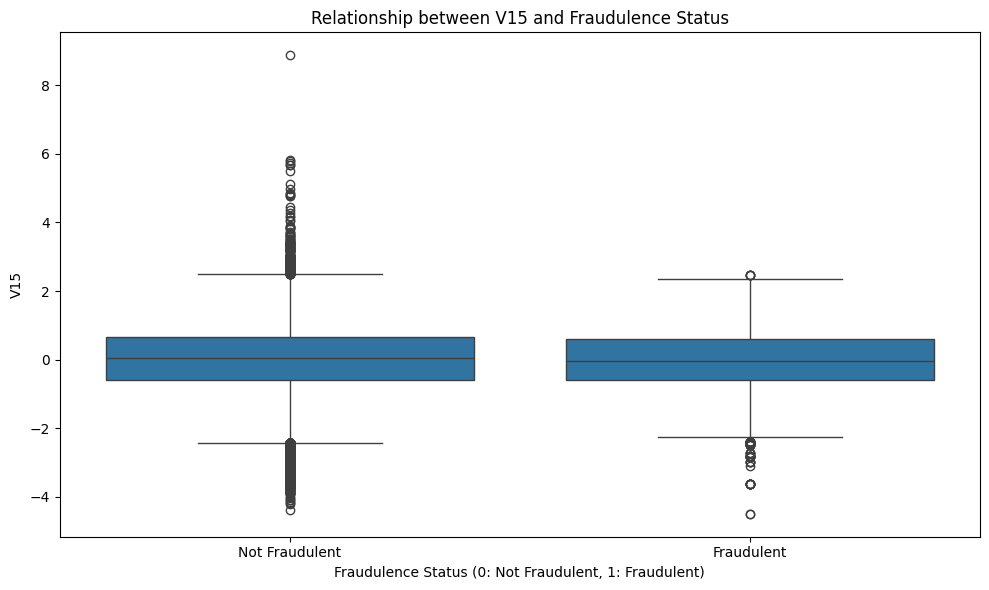


Analysis for column: V16

Descriptive statistics:


,V16
count,286315.000000
mean,-0.021966
std,0.967705
min,-14.129855
25%,-0.475833
50%,0.063201
75%,0.521604
max,17.315112


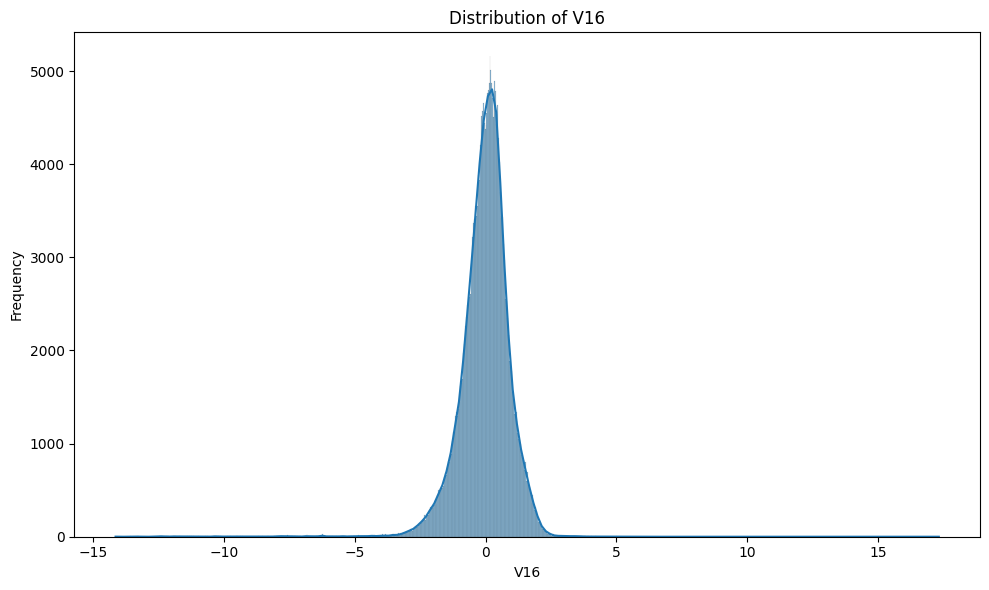

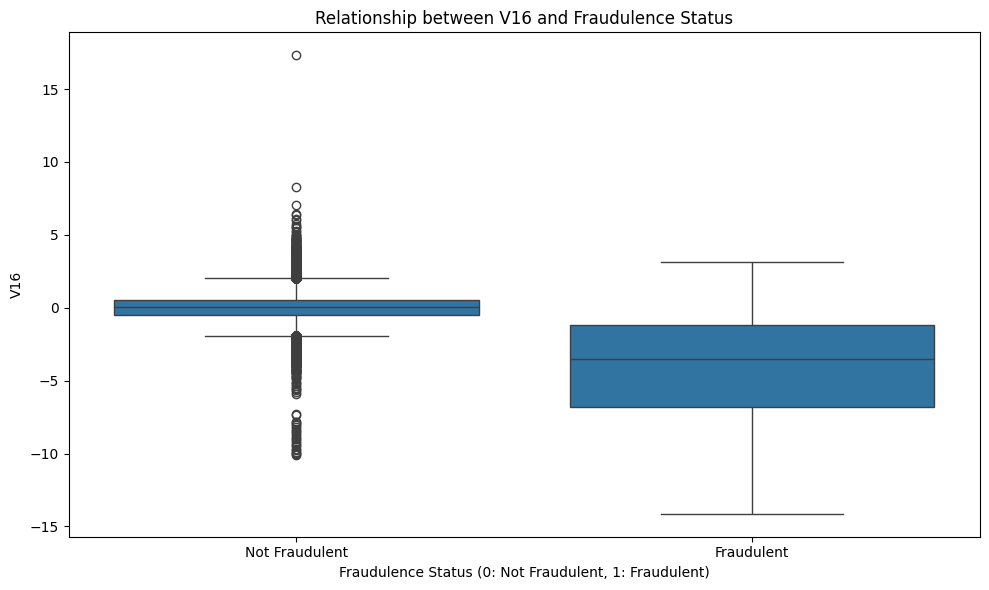


Analysis for column: V17

Descriptive statistics:


,V17
count,286315.000000
mean,-0.035151
std,1.100456
min,-25.162799
25%,-0.488649
50%,-0.068371
75%,0.398658
max,9.253526


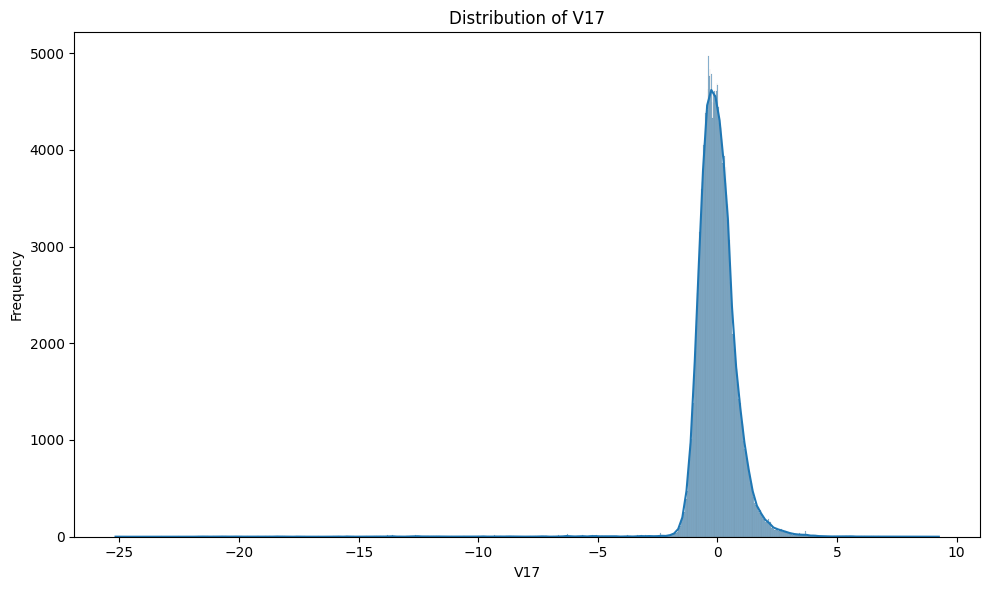

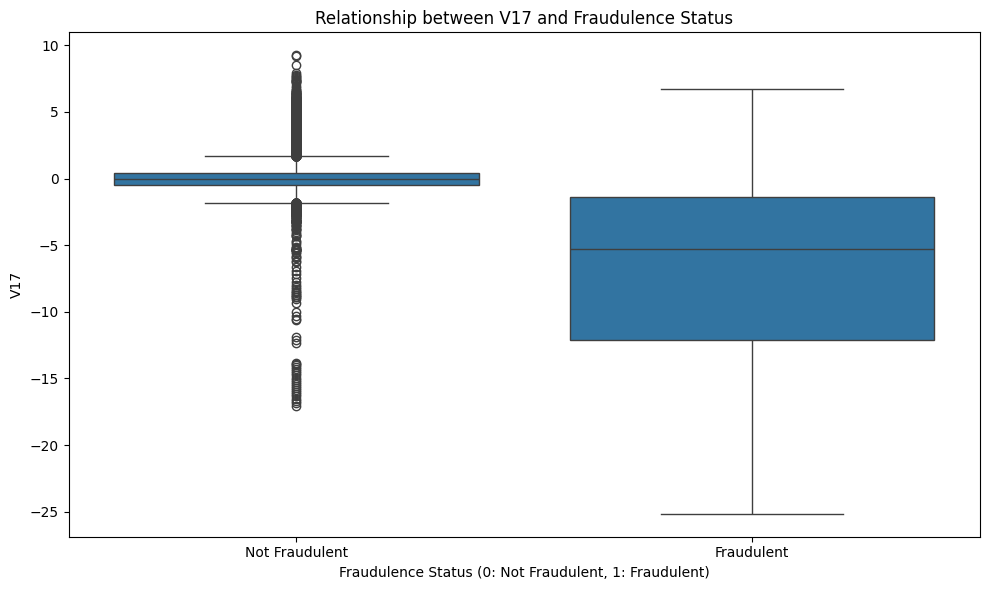


Analysis for column: V18

Descriptive statistics:


,V18
count,286315.000000
mean,-0.011777
std,0.877397
min,-9.498746
25%,-0.502948
50%,-0.006067
75%,0.499828
max,5.041069


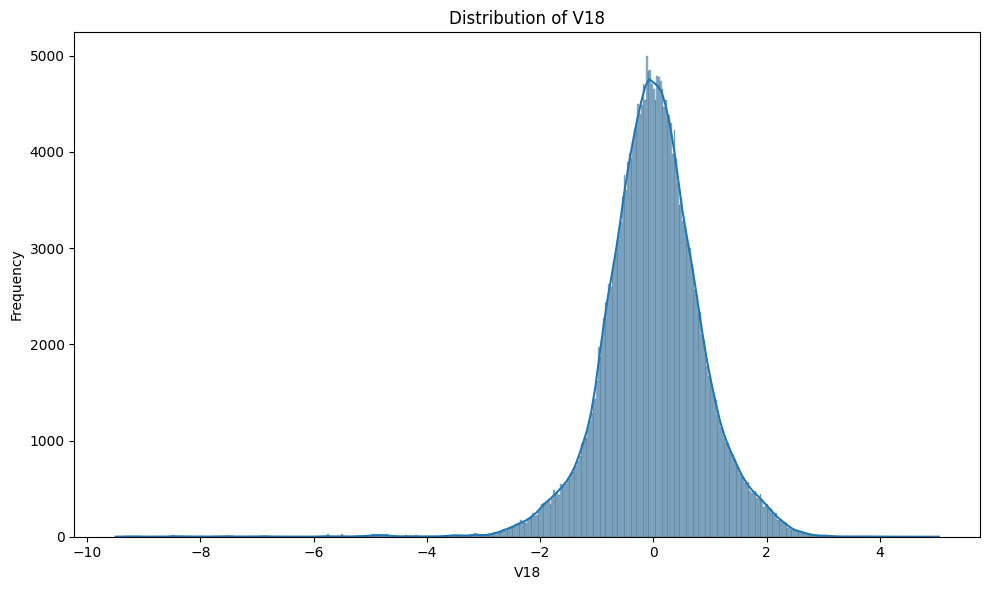

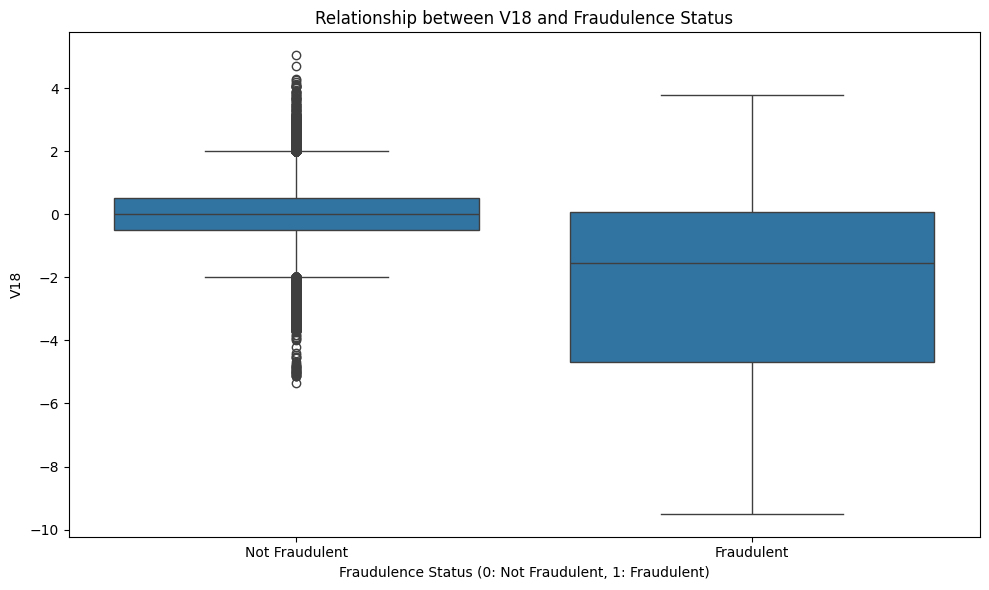


Analysis for column: V19

Descriptive statistics:


,V19
count,286315.000000
mean,0.003801
std,0.821054
min,-7.213527
25%,-0.455949
50%,0.005656
75%,0.462855
max,5.591971


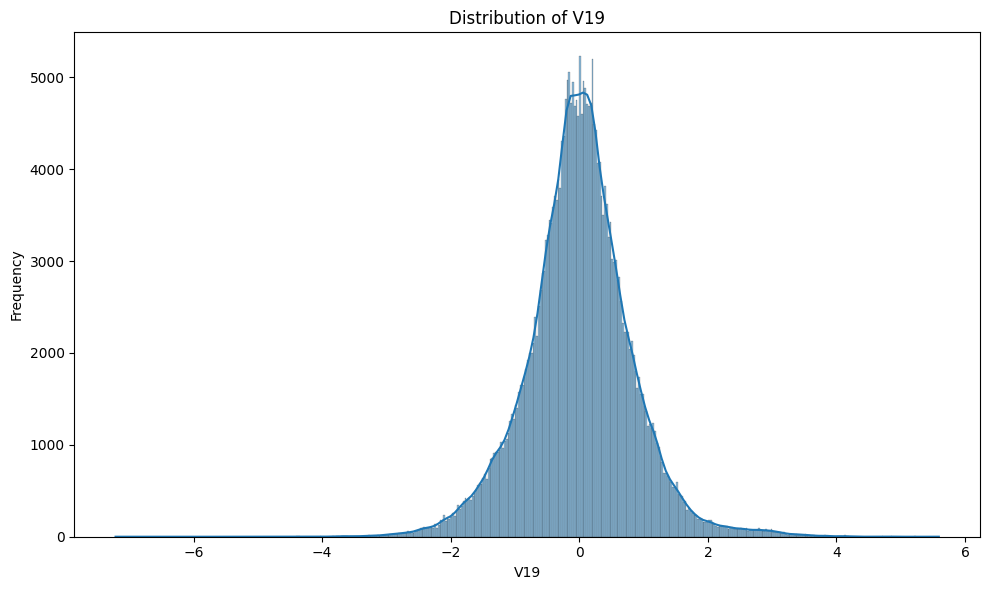

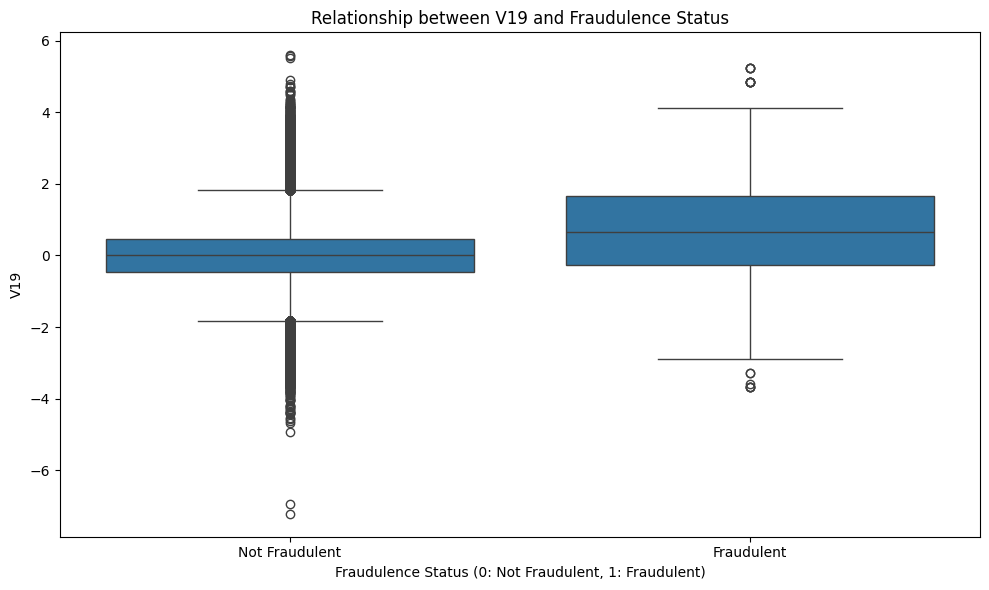


Analysis for column: V20

Descriptive statistics:


,V20
count,286315.000000
mean,0.001396
std,0.774501
min,-54.497720
25%,-0.211680
50%,-0.062040
75%,0.134791
max,39.420904


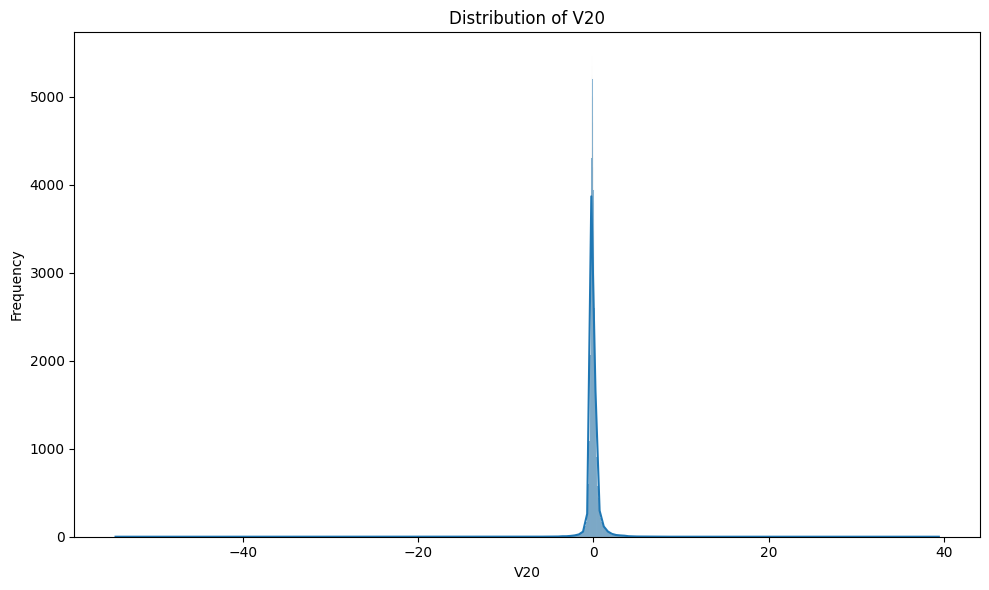

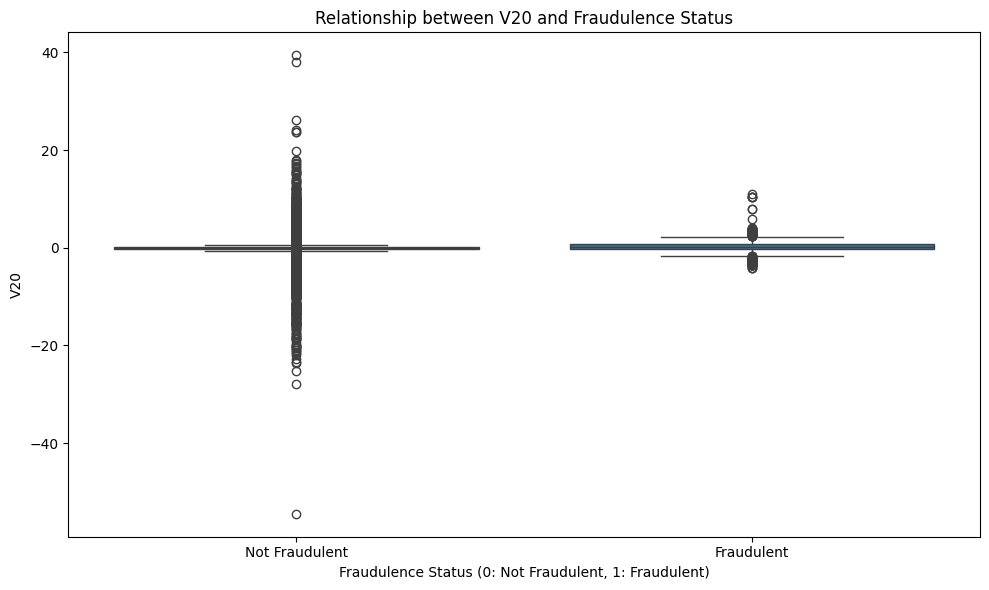


Analysis for column: V21

Descriptive statistics:


,V21
count,286315.000000
mean,0.005308
std,0.793311
min,-34.830382
25%,-0.228148
50%,-0.028469
75%,0.188609
max,27.202839


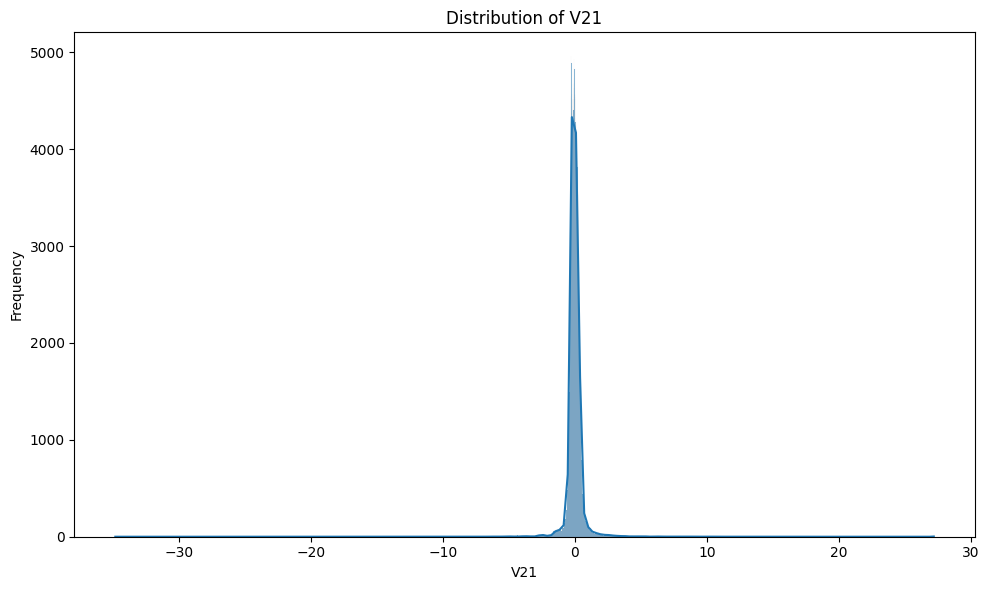

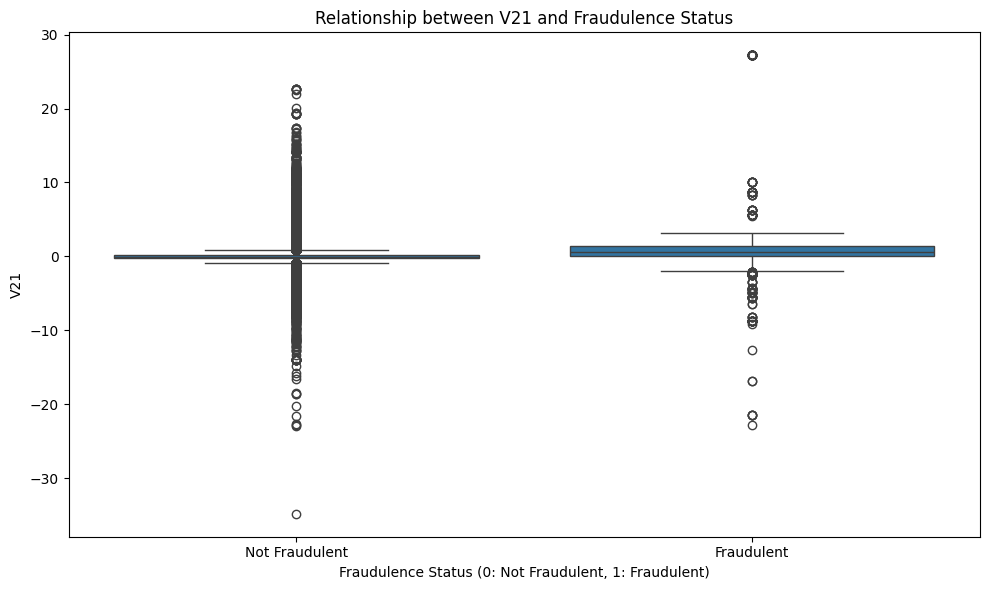


Analysis for column: V22

Descriptive statistics:


,V22
count,286315.000000
mean,-0.000239
std,0.732199
min,-10.933144
25%,-0.542344
50%,0.007077
75%,0.529161
max,10.503090


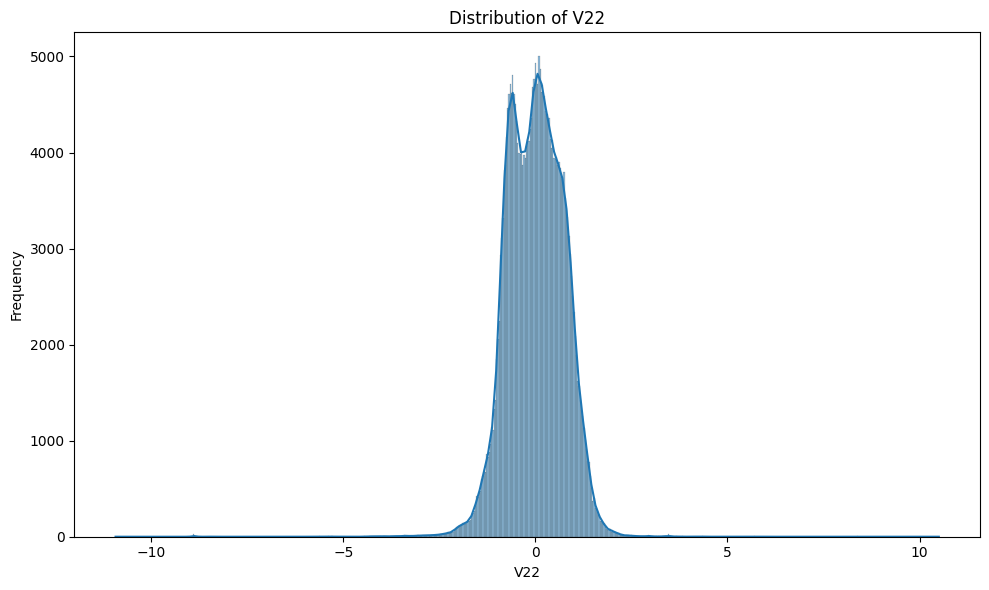

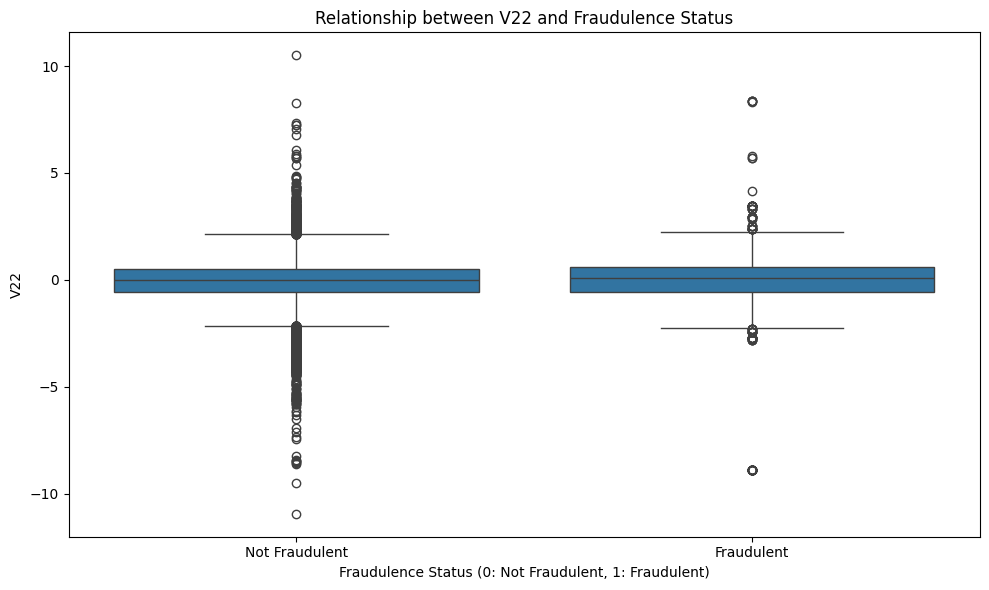


Analysis for column: V23

Descriptive statistics:


,V23
count,286315.000000
mean,0.000147
std,0.631161
min,-44.807735
25%,-0.162328
50%,-0.011301
75%,0.148145
max,22.528412


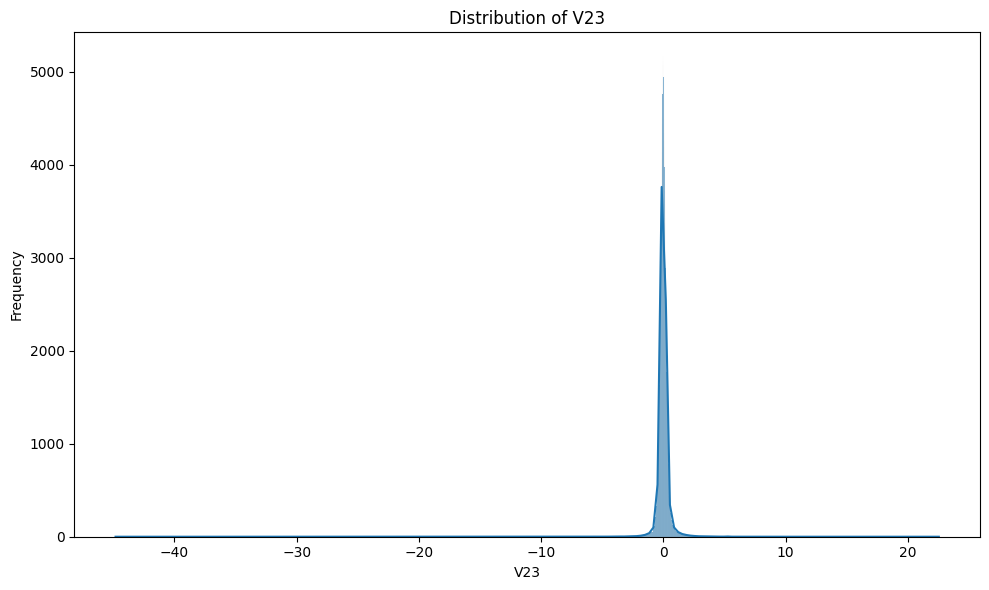

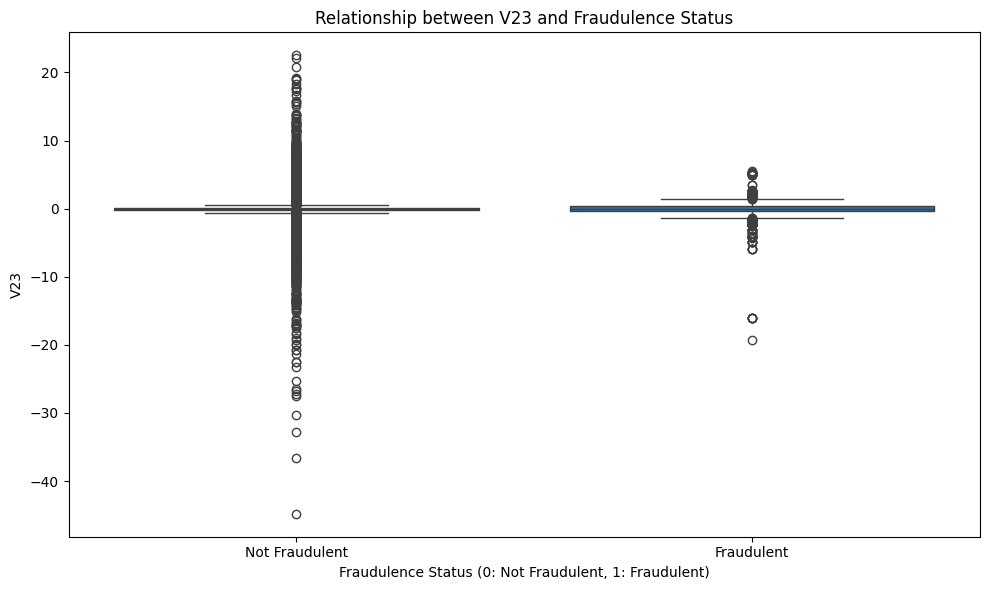


Analysis for column: V24

Descriptive statistics:


,V24
count,286315.000000
mean,-0.000671
std,0.605376
min,-2.836627
25%,-0.355409
50%,0.040631
75%,0.438711
max,4.584549


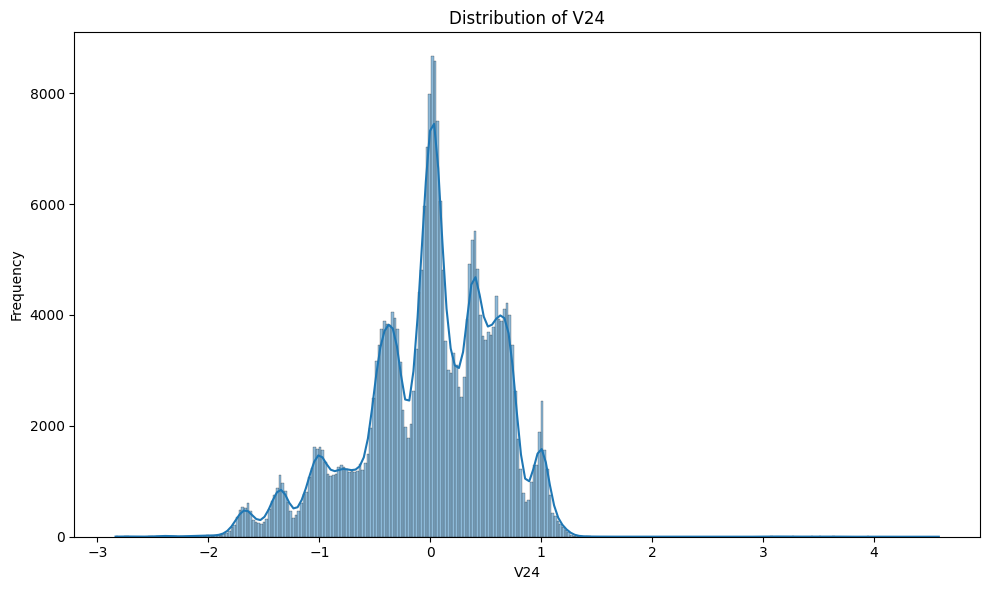

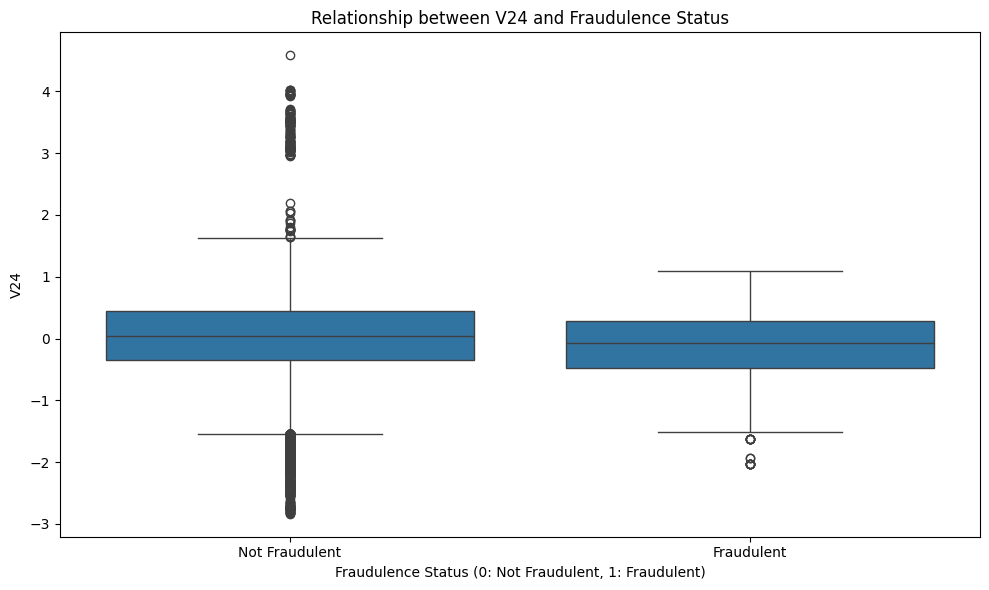


Analysis for column: V25

Descriptive statistics:


,V25
count,286315.000000
mean,0.000073
std,0.522728
min,-10.295397
25%,-0.317220
50%,0.016925
75%,0.351185
max,7.519589


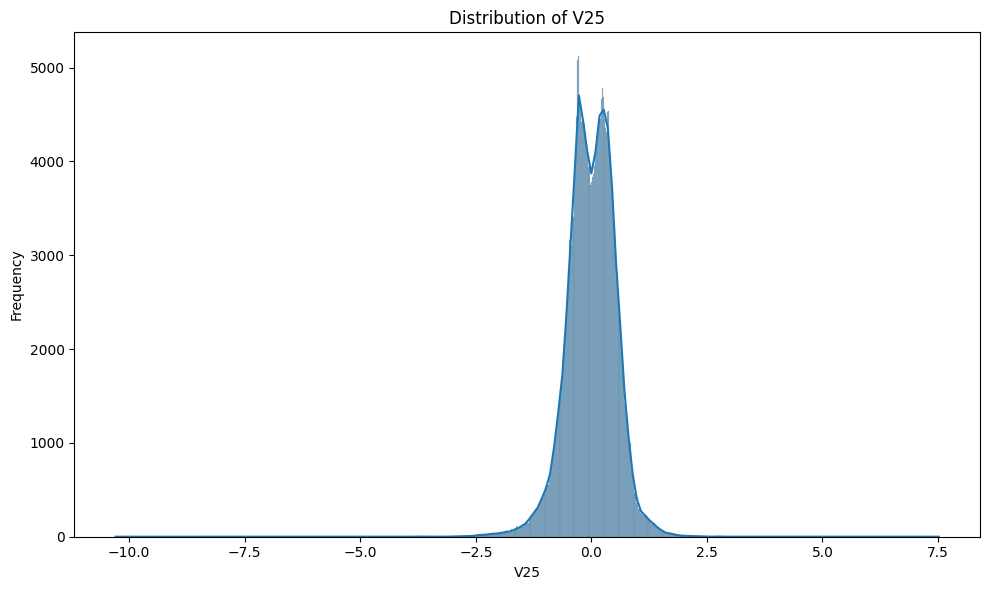

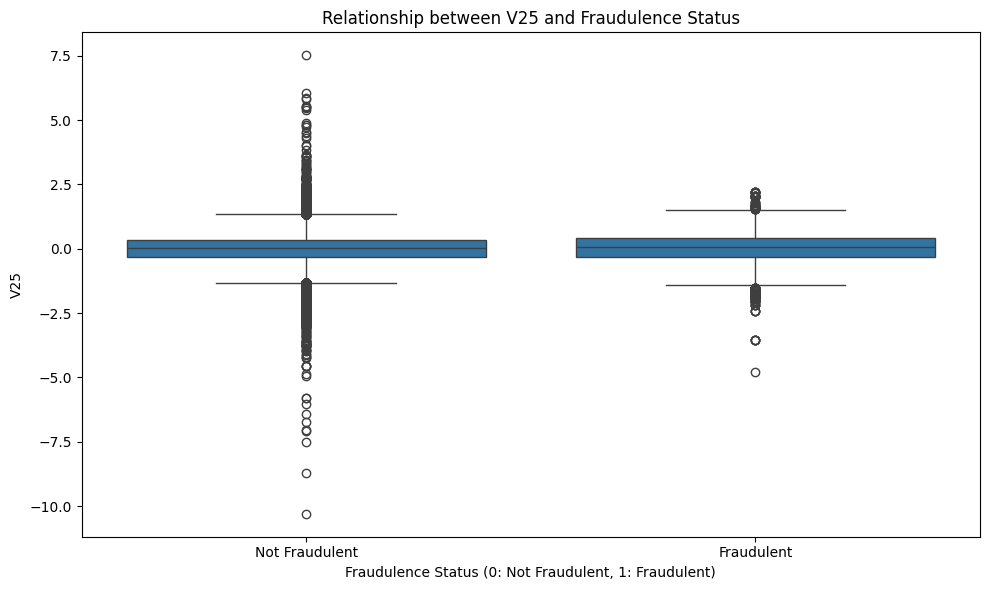


Analysis for column: V26

Descriptive statistics:


,V26
count,286315.000000
mean,0.000214
std,0.482259
min,-2.604551
25%,-0.326836
50%,-0.051817
75%,0.241833
max,3.517346


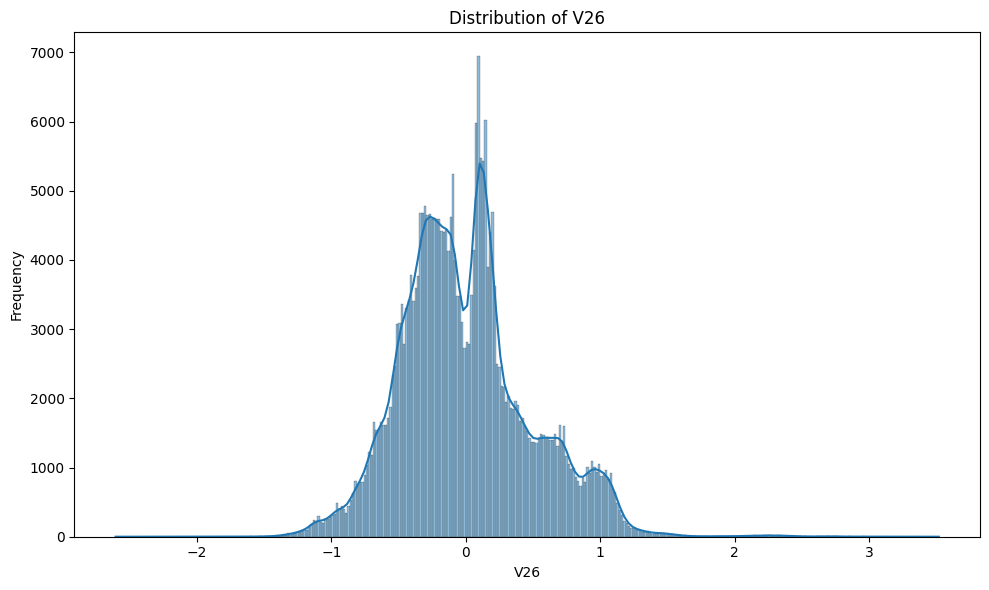

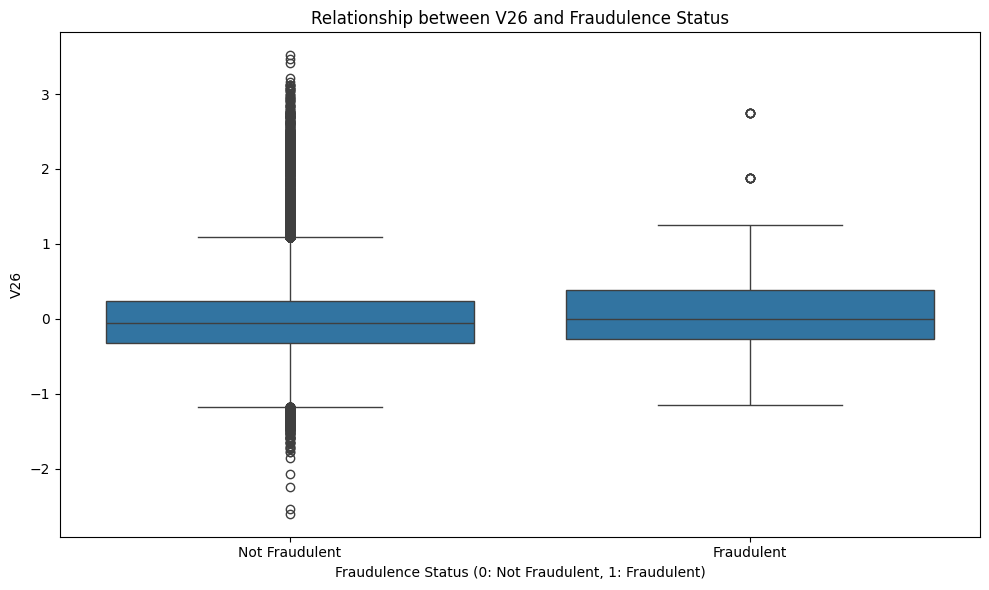


Analysis for column: V27

Descriptive statistics:


,V27
count,286315.000000
mean,0.000797
std,0.415420
min,-22.565679
25%,-0.070823
50%,0.001647
75%,0.092453
max,31.612198


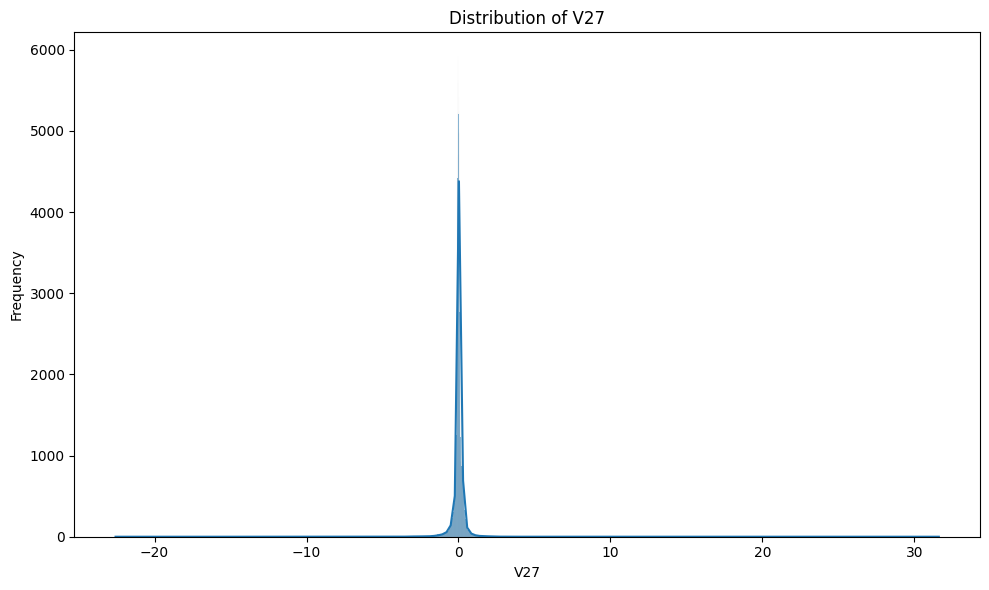

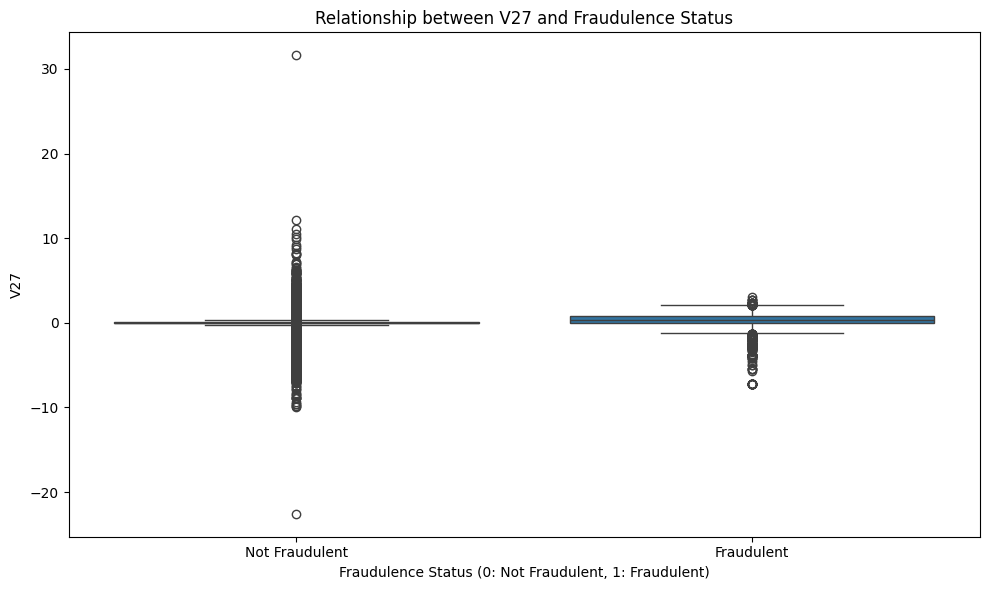


Analysis for column: V28

Descriptive statistics:


,V28
count,286315.000000
mean,0.000247
std,0.332052
min,-15.430084
25%,-0.053024
50%,0.011369
75%,0.079128
max,33.847808


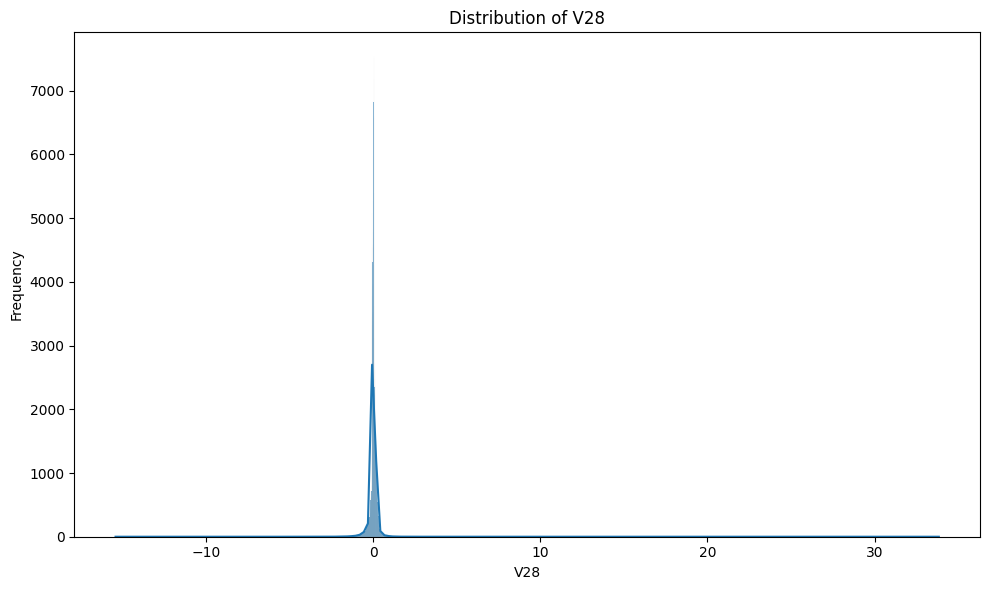

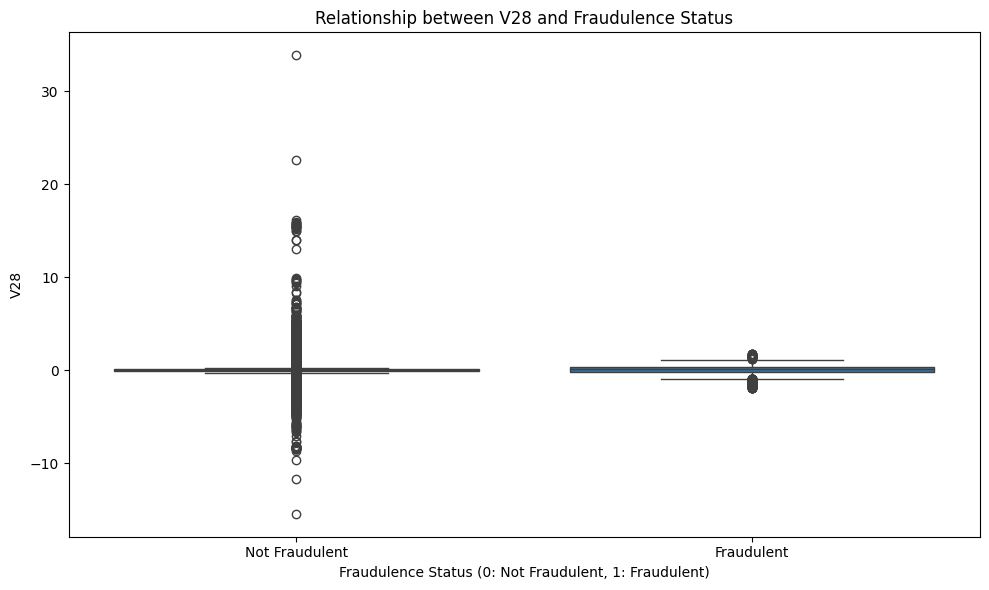


Analysis for column: Amount

Descriptive statistics:


,Amount
count,286315.000000
mean,92.684657
std,368.354476
min,0.000000
25%,5.490000
50%,22.000000
75%,77.695000
max,25691.160000


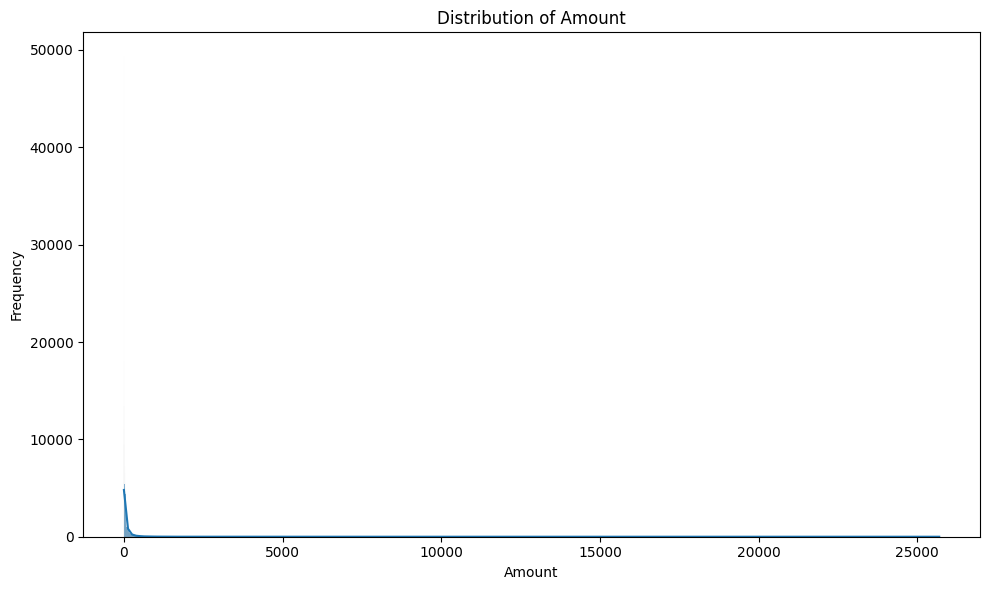

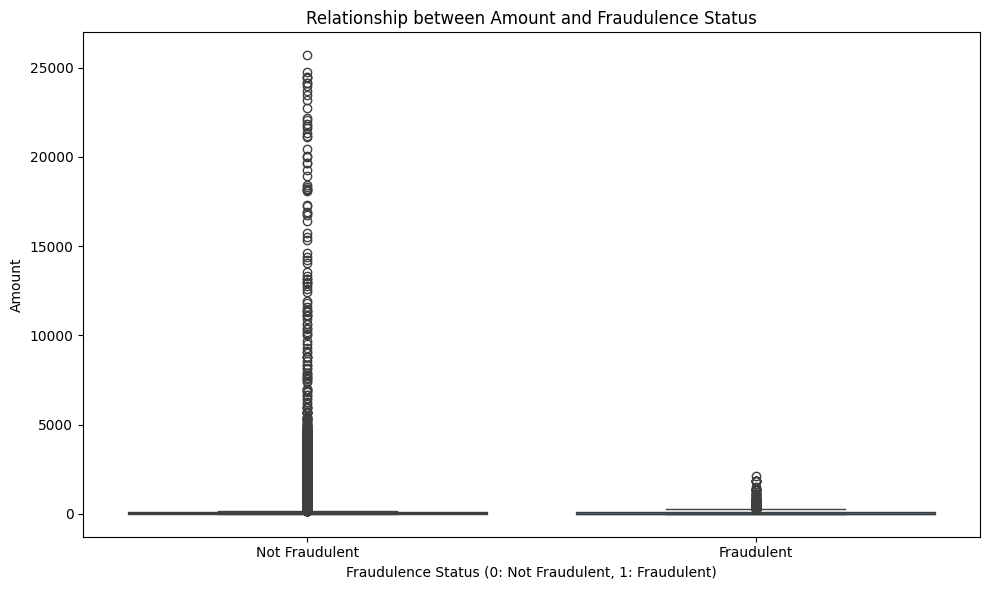


Analysis for column: hour

Descriptive statistics:


,hour
count,286315.000000
mean,14.032859
std,5.843513
min,0.000000
25%,10.000000
50%,15.000000
75%,19.000000
max,23.000000


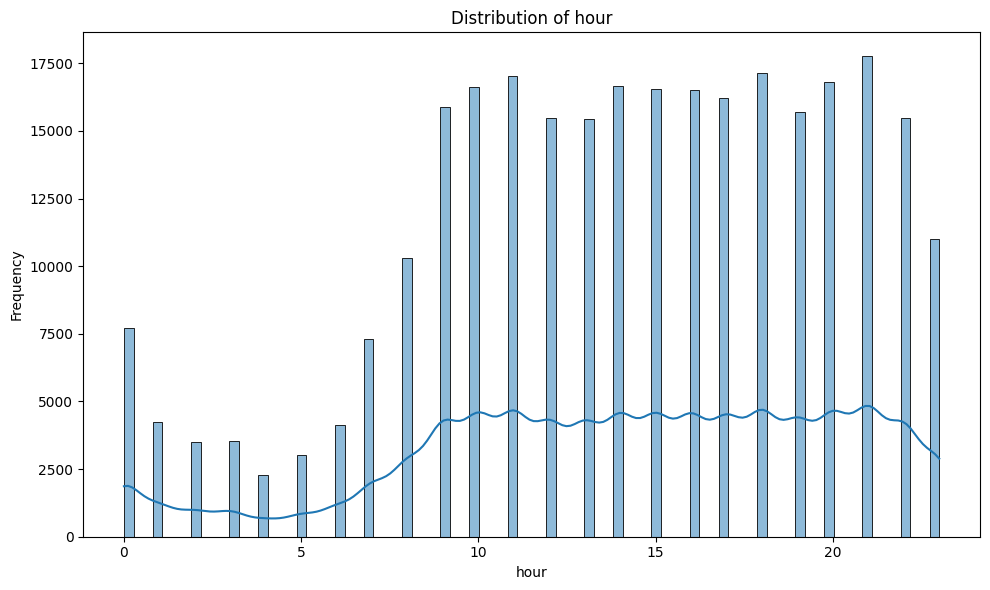

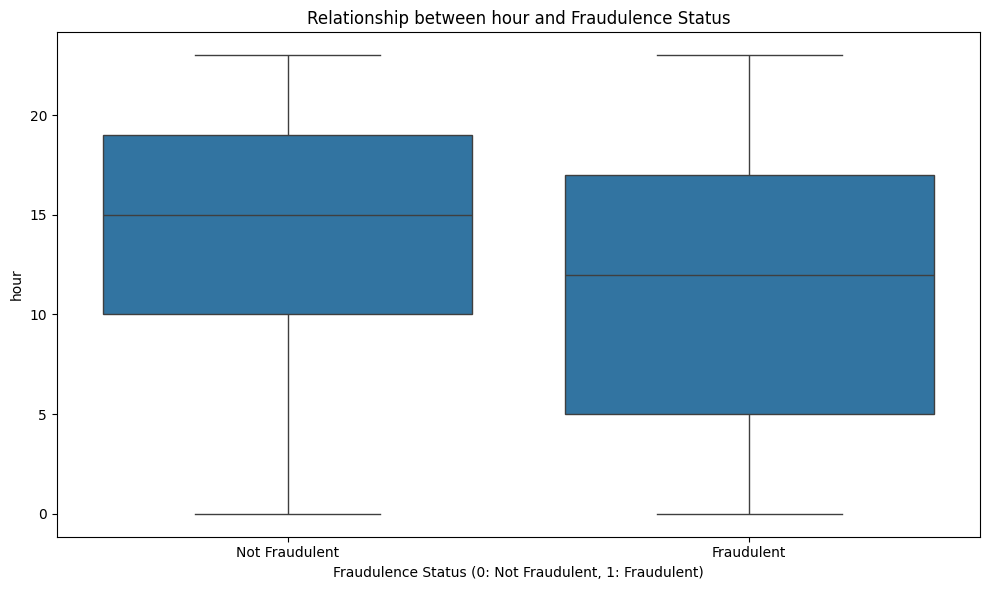


Analysis for column: age

Descriptive statistics:


,age
count,286068.000000
mean,49.844261
std,18.113252
min,18.000000
25%,35.000000
50%,50.000000
75%,66.000000
max,79.000000


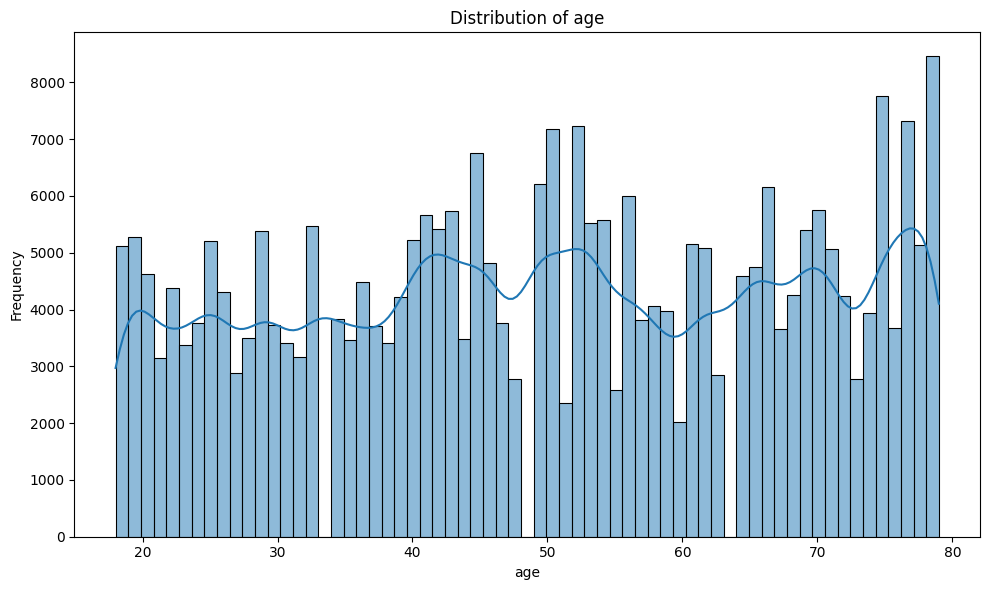

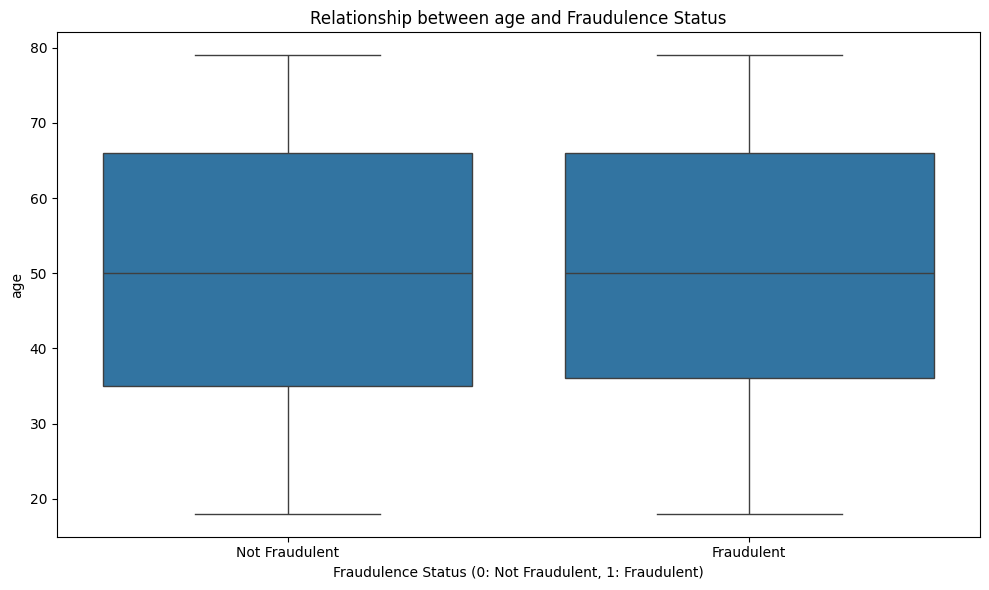


Analysis for column: credit_score

Descriptive statistics:


,credit_score
count,286068.000000
mean,652.938343
std,103.595359
min,300.000000
25%,587.000000
50%,657.000000
75%,726.000000
max,850.000000


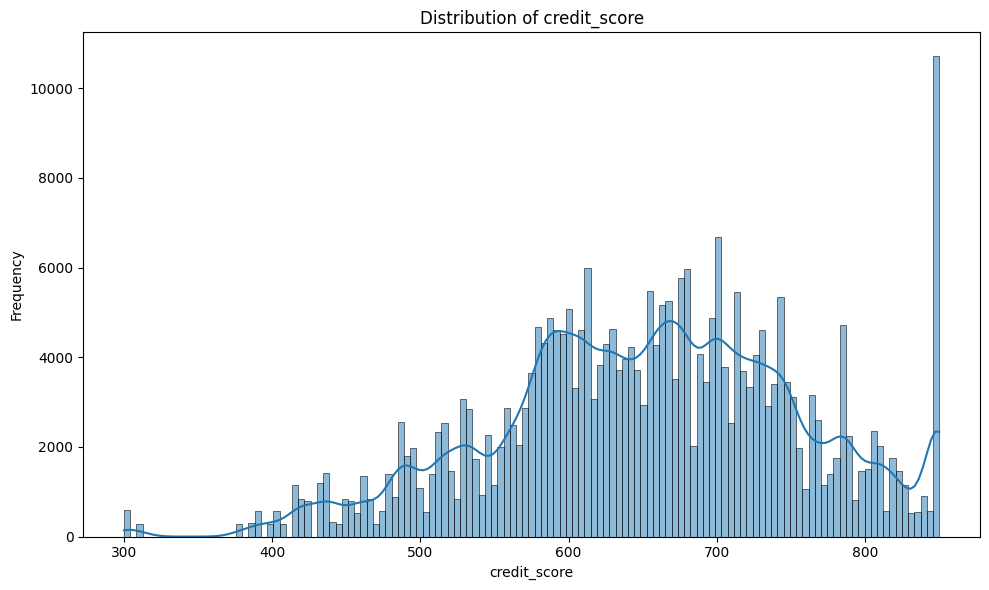

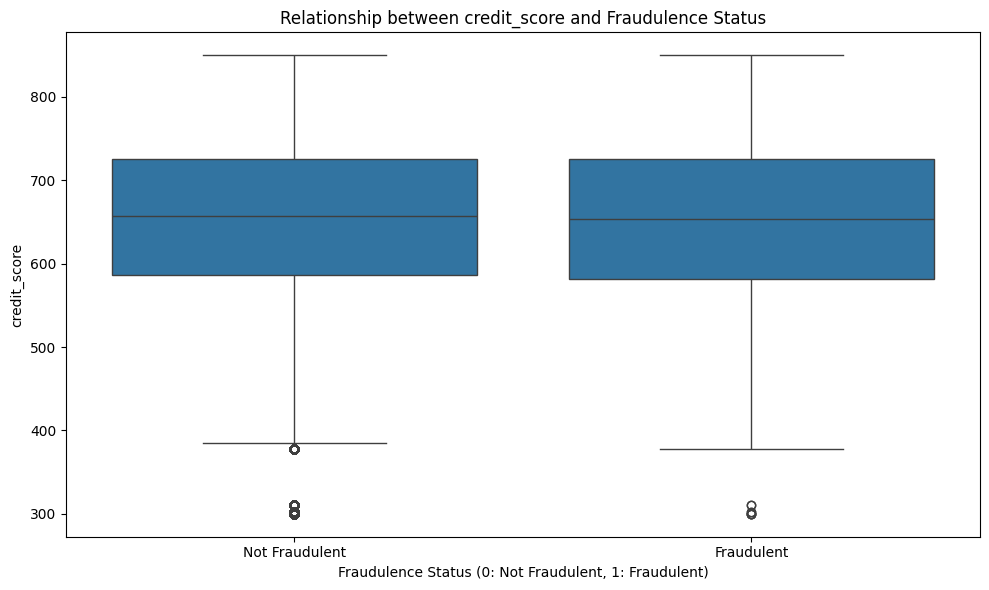

In [41]:
for col in numeric_df:
    print(f"\nAnalysis for column: {col}")

    # Calculate descriptive statistics
    print("\nDescriptive statistics:")
    display(df[col].describe())

    # Visualize distribution of the numeric variable
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    # Analyze relationship with survival_status
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='Class', y=col)
    plt.title(f'Relationship between {col} and Fraudulence Status')
    plt.xlabel('Fraudulence Status (0: Not Fraudulent, 1: Fraudulent)')
    plt.ylabel(col)
    plt.xticks([0, 1], ['Not Fraudulent', 'Fraudulent'])
    plt.tight_layout()
    plt.show()

## Categorical Variables

In [42]:
# From the variable info, some columns are described as binary or categorical
# but are stored as integers. We should also include these based on the description.

for col in categoric_vars:
    print(f"\nAnalysis for column: {col}")

    # Calculate frequency of each category
    print("\nFrequency of each category:")
    display(df[col].value_counts())

    # Calculate frequency of each category in relation to fraudulence_status
    print(f"\nFrequency by {col} and fraudulence_status:")
    display(pd.crosstab(df[col], df['Class']))

    # Visualize distribution of categorical variables
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Visualize relationship between categorical variable and fraudulence_status
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col, hue='Class', order=df[col].value_counts().index)
    plt.title(f'Relationship between {col} and Fraudulence Status')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Fraudulence Status', labels=['Not Fraudulent', 'Fraudulent'])
    plt.tight_layout()
    plt.show()


Analysis for column: ip_address

Frequency of each category:


,count
ip_address,
152.172.26.33,2
169.91.47.89,2
31.228.210.51,2
222.135.249.29,2
213.115.253.160,2
...,...
60.119.212.96,1
190.180.53.169,1
9.244.206.141,1



Frequency by ip_address and fraudulence_status:


Class,0,1
ip_address,,
1.0.43.74,1,0
1.1.134.246,1,0
1.1.18.48,1,0
1.1.224.106,1,0
1.1.226.213,1,0
...,...,...
99.99.196.212,1,0
99.99.39.56,1,0
99.99.49.99,1,0


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7e2fe0e84e00> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7e2fc982d940> (for post_execute):


KeyboardInterrupt: 

## Binary Variables

In [ ]:
# From the variable info, some columns are described as binary
# but are stored as integers. We should also include these based on the description.
for col in binary_vars:
    print(f"\nAnalysis for column: {col}")


    # Calculate frequency of each category
    print("\nFrequency of each category:")
    display(df[col].value_counts())


    # Calculate frequency of each category in relation to fraudulence_status
    print(f"\nFrequency by {col} and fraudulence_status:")
    display(pd.crosstab(df[col], df['Class']))


    # Visualize distribution of binary variables
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


    # Visualize relationship between binary variable and fraudulence_status
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col, hue='Class', order=df[col].value_counts().index)
    plt.title(f'Relationship between {col} and Fraudulence Status')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Fraudulence Status', labels=['Not Fraudulent', 'Fraudulent'])
    plt.tight_layout()
    plt.show()
